In [33]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from itertools import product

class CustomMLP(tf.keras.Model):
    """
    A customizable Multi-Layer Perceptron (MLP) model.

    Parameters:
    - layer_sizes: List[int], number of neurons per hidden layer.
    - activation_fn: String or tf.keras activation function, activation for hidden layers.
    - output_units: int, number of output neurons (number of classes).
    """
    def __init__(self, layer_sizes, activation_fn, output_units):
        super(CustomMLP, self).__init__()
        self.hidden_layers = []
        for size in layer_sizes:
            self.hidden_layers.append(tf.keras.layers.Dense(size, activation=activation_fn))
        # Output layer: no activation here, apply softmax later if needed
        self.output_layer = tf.keras.layers.Dense(output_units)

    def call(self, inputs, training=False):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        logits = self.output_layer(x)
        return logits

def load_class_mapping(mapping_path):
    """
    Loads class names from the mapping file and returns both a list and a dictionary.
    Each line is expected to have 'class_name<TAB>index'.
    """
    class_names = []
    with open(mapping_path, "r") as f:
        for line in f:
            # Split by tab and take the first part as class name
            parts = line.strip().split("\t")
            if len(parts) > 0:
                class_names.append(parts[0])
    class_to_index = {name: idx for idx, name in enumerate(class_names)}
    return class_names, class_to_index

def parse_image_list(file_path, image_base_path, class_to_index):
    """
    Parses the image file list and returns full image paths and corresponding labels.
    Cleans lines by removing trailing tab and class index,
    and removes 'images/' prefix if present to avoid duplicated folder.
    """
    image_paths = []
    labels = []

    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            # Remove the tab and index if present
            if '\t' in line:
                relative_path, label_str = line.split('\t')
            else:
                relative_path = line

            # Remove leading 'images/' if present to avoid duplication
            if relative_path.startswith("images/"):
                relative_path = relative_path[len("images/"):]

            class_name = relative_path.split("/")[0]
            full_image_path = image_base_path / relative_path

            if full_image_path.exists():
                image_paths.append(str(full_image_path))
                labels.append(class_to_index[class_name])
            else:
                print(f"Warning: Image not found -> {full_image_path}")

    return image_paths, labels



def load_images(image_paths, target_size=(28, 28)):
    """
    Loads and resizes grayscale images from a list of paths. Returns a NumPy array.
    """
    images = []
    for path in image_paths:
        with Image.open(path).convert("L") as img:
            img_resized = img.resize(target_size)  # Resize if needed
            img_array = np.asarray(img_resized, dtype=np.float32) / 255.0
            images.append(img_array)
    return np.stack(images)

def load_quickdraw_dataset(base_dir, split="train", target_size=(28, 28)):
    """
    Loads the full QuickDraw-10 dataset split (train/test).
    Returns: images (N, H, W), labels (N,), class_names (list).
    """
    base_path = Path(base_dir)
    image_folder = base_path / "images"
    file_list = base_path / f"{split}.txt"
    mapping_file = base_path / "mapping.txt"

    class_names, class_to_index = load_class_mapping(mapping_file)
    image_paths, labels = parse_image_list(file_list, image_folder, class_to_index)
    images = load_images(image_paths, target_size)
    labels = np.array(labels)

    return images, labels, class_names

def load_quickdraw_animals_dataset(base_dir, split="train", target_size=(28, 28)):
    """
    Loads the full QuickDraw-Animals dataset split (train/test).
    Returns: images (N, H, W), labels (N,), class_names (list).
    """
    base_path = Path(base_dir)
    image_folder = base_path / f"{split}_images"  
    mapping_file = base_path / "mapping.txt"

    class_names, class_to_index = load_class_mapping(mapping_file)
    
    image_paths = []
    labels = []
    for class_name in class_names:
        class_folder = image_folder / class_name
        if not class_folder.exists():
            print(f"Warning: Class folder not found: {class_folder}")
            continue
        for file in class_folder.glob("*.jpg"): 
            image_paths.append(str(file))
            labels.append(class_to_index[class_name])

    images = load_images(image_paths, target_size)
    labels = np.array(labels)
    return images, labels, class_names

def plot_class_distribution(labels, class_names=None, title="Class Distribution"):
    """
    Plots the distribution of class labels.

    Args:
        labels (numpy.ndarray or list): Array of labels. Can be numeric class indices or one-hot encoded.
        class_names (list, optional): List of class names corresponding to label indices.
        title (str): Title of the plot.
    """
    # If labels are one-hot encoded, convert to class indices
    if len(labels.shape) > 1 and labels.shape[1] > 1:
        labels = np.argmax(labels, axis=1)

    # Count occurrences of each class
    classes, counts = np.unique(labels, return_counts=True)

    # Use class names if provided, else numeric indices
    if class_names:
        labels_to_plot = [class_names[c] for c in classes]
    else:
        labels_to_plot = classes

    plt.figure(figsize=(10,6))
    plt.bar(labels_to_plot, counts, color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Number of samples")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def apply_pca(X_train, X_test, n_components):
    """
    Applies Principal Component Analysis (PCA) to reduce the dimensionality
    of training and test datasets.

    Args:
        X_train (numpy.ndarray): Training data, shape (n_samples_train, n_features).
        X_test (numpy.ndarray): Test data, shape (n_samples_test, n_features).
        n_components (int): Number of principal components to keep.

    Returns:
        X_train_pca (numpy.ndarray): Transformed training data.
        X_test_pca (numpy.ndarray): Transformed test data.
        pca_model (PCA): Fitted PCA model (can be used later for inverse transform or analysis).
    """
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca

def build_and_compile_mlp(layer_sizes, activation, output_units, loss_fn, learning_rate=0.01):
    """
    Builds and compiles a CustomMLP model.

    Args:
    - layer_sizes (list of int): hidden layer sizes.
    - activation (str or callable): activation function for hidden layers.
    - output_units (int): number of output classes.
    - loss_fn (str or tf.keras.losses.Loss): loss function.
    - learning_rate (float): optimizer learning rate.

    Returns:
    - Compiled tf.keras.Model.
    """
    model = CustomMLP(layer_sizes, activation, output_units)
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=['accuracy']
    )
    return model

def train_and_evaluate(model_builder, X_train, y_train, X_test, y_test, runs=5, epochs=20, batch_size=32):
    """
    Trains and evaluates the same model multiple times with different initial weights.

    Args:
    - model_builder: function returning a compiled model instance.
    - X_train, y_train: training data and labels (one-hot encoded).
    - X_test, y_test: test data and labels (one-hot encoded).
    - runs: int, how many independent trainings to perform.
    - epochs: int, training epochs per run.
    - batch_size: int, batch size.

    Returns:
    - List of dicts with 'history', 'accuracy', and 'confusion_matrix' for each run.
    """
    results = []
    for run in range(runs):
        print(f"Run {run+1}/{runs}")

        # Build fresh model
        model = model_builder()

        # Train
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )

        plot_training_history(history, model_name=f"Run {run+1}")

        # Evaluate
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test accuracy: {test_acc:.4f}")

        # Predictions & confusion matrix
        y_pred = np.argmax(model.predict(X_test), axis=1)
        y_true = np.argmax(y_test, axis=1)
        cm = tf.math.confusion_matrix(y_true, y_pred).numpy()

        results.append({
            'history': history,
            'accuracy': test_acc,
            'confusion_matrix': cm
        })

    return results

def plot_training_history(history, model_name="Model"):
    """
    Plots training and validation accuracy over epochs.

    Args:
        history (tf.keras.callbacks.History): History object from model.fit().
        model_name (str): Name of the model for title.
    """
    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy per Epoch - {model_name}')
    plt.legend()
    # Set limits
    plt.ylim(0, 1)      # y-axis limit from 0 to 1
    plt.xlim(0, 20)     # x-axis limit from 0 to 20 epochs
    
    # Set ticks every 2 units on x axis
    plt.xticks(np.arange(0, 21, 2))
    # Optionally, set y ticks every 0.1 units
    plt.yticks(np.arange(0, 1.1, 0.1))
    
    plt.grid(True)
    plt.show()
    
def create_builder(config, num_classes):
    def builder():
        return build_and_compile_mlp(
            layer_sizes=config["layer_sizes"],
            activation=config["activation"],
            output_units=num_classes,
            loss_fn=config["loss"]
        )
    return builder

all_results = {}

In [34]:
# For QuickDraw-10 (txt + images folder)
train_images, train_labels, class_names = load_quickdraw_dataset("/home/mapacheroja/Escritorio/Tarea2/QuickDraw-10", split="train")
test_images, test_labels, _ = load_quickdraw_dataset("/home/mapacheroja/Escritorio/Tarea2/QuickDraw-10", split="test")

# For QuickDraw-Animals (folder structure)
animals_train_images, animals_train_labels, animal_class_names = load_quickdraw_animals_dataset(
    "/home/mapacheroja/Escritorio/Tarea2/QuickDraw-Animals", split="train"
)
animals_test_images, animals_test_labels, _ = load_quickdraw_animals_dataset(
    "/home/mapacheroja/Escritorio/Tarea2/QuickDraw-Animals", split="test"
)


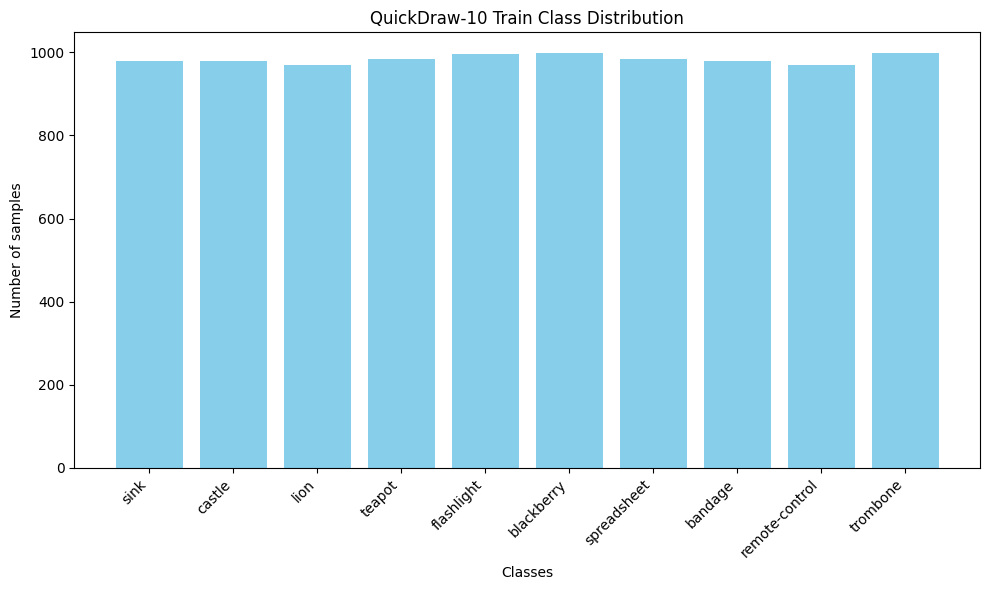

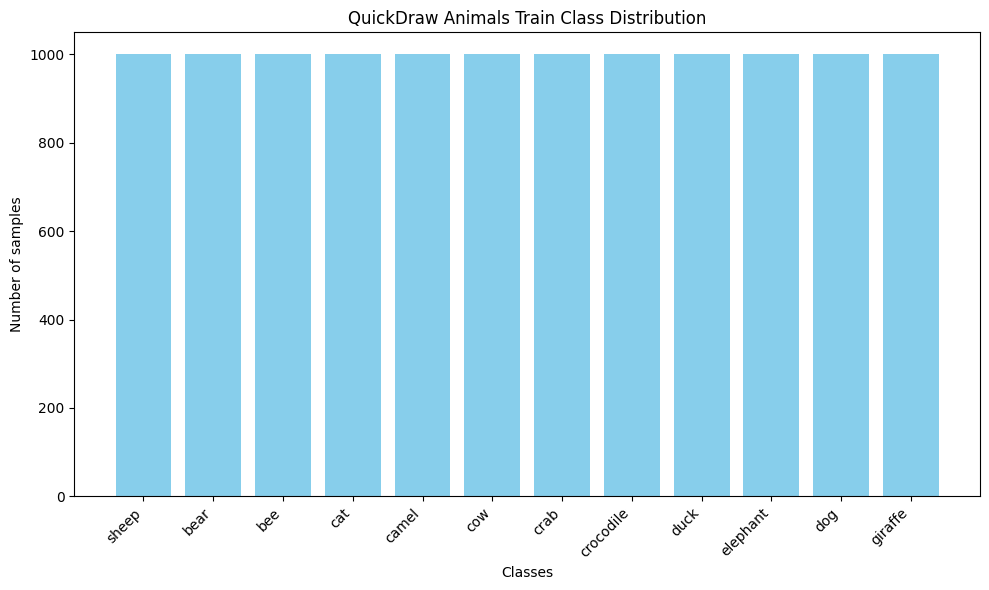

In [35]:
# Plot class distribution per dataset
plot_class_distribution(train_labels, class_names, title="QuickDraw-10 Train Class Distribution")

plot_class_distribution(animals_train_labels, animal_class_names, title="QuickDraw Animals Train Class Distribution")


In [39]:
# QuickDraw-10
num_classes = len(class_names)

X_train_flat = train_images.reshape(len(train_images), -1)
X_test_flat = test_images.reshape(len(test_images), -1)

X_train_pca, X_test_pca, pca_model = apply_pca(X_train_flat, X_test_flat, n_components=256)

y_train_onehot = tf.keras.utils.to_categorical(train_labels, num_classes)
y_test_onehot = tf.keras.utils.to_categorical(test_labels, num_classes)

# QuickDraw-Animals
num_classes_animals = len(animal_class_names)

X_train_animals_flat = animals_train_images.reshape(len(animals_train_images), -1)
X_test_animals_flat = animals_test_images.reshape(len(animals_test_images), -1)

X_train_animals_pca, X_test_animals_pca, pca_model_animals = apply_pca(X_train_animals_flat, X_test_animals_flat, n_components=256)

y_train_animals_onehot = tf.keras.utils.to_categorical(animals_train_labels, num_classes_animals)
y_test_animals_onehot = tf.keras.utils.to_categorical(animals_test_labels, num_classes_animals)

Training with config: {'layer_sizes': [512, 256], 'activation': 'relu', 'loss': 'categorical_crossentropy'}
Run 1/5


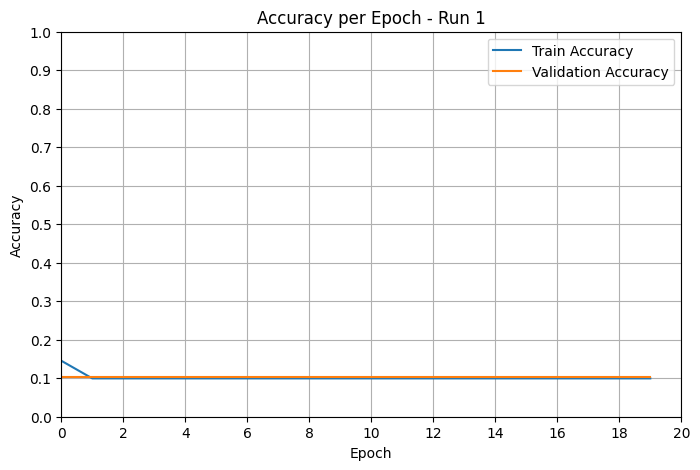

Test accuracy: 0.1038
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


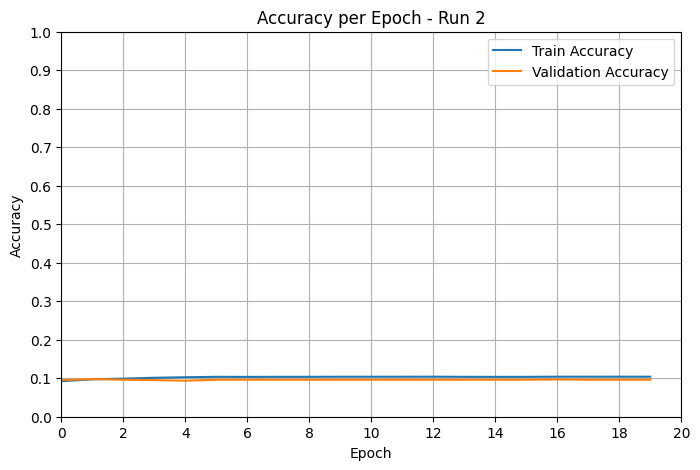

Test accuracy: 0.0961
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


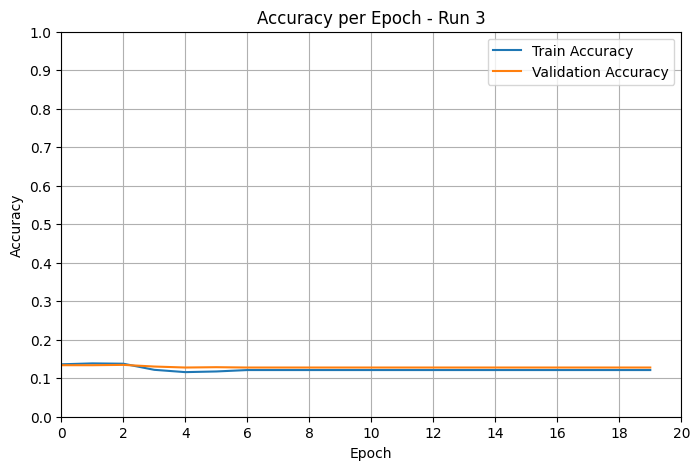

Test accuracy: 0.1278
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


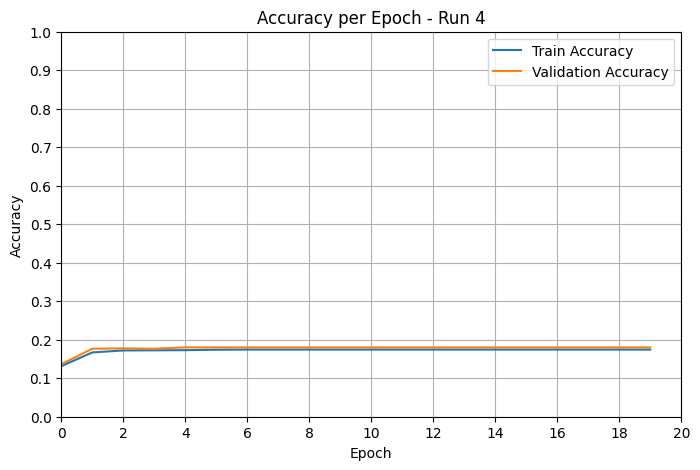

Test accuracy: 0.1801
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


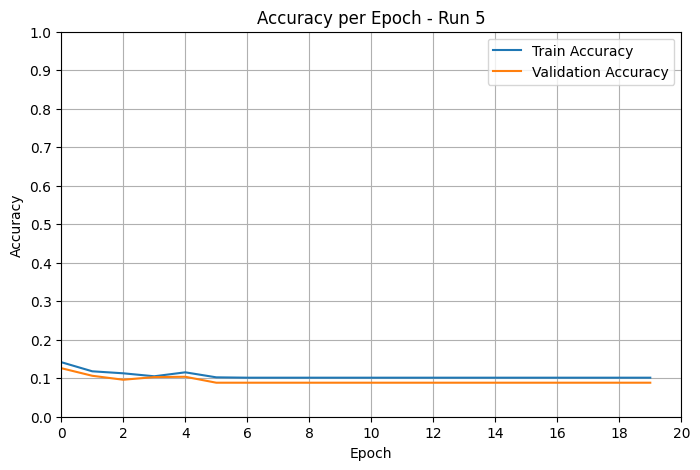

Test accuracy: 0.0883
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [512, 256], 'activation': 'relu', 'loss': 'mean_squared_error'}
Run 1/5


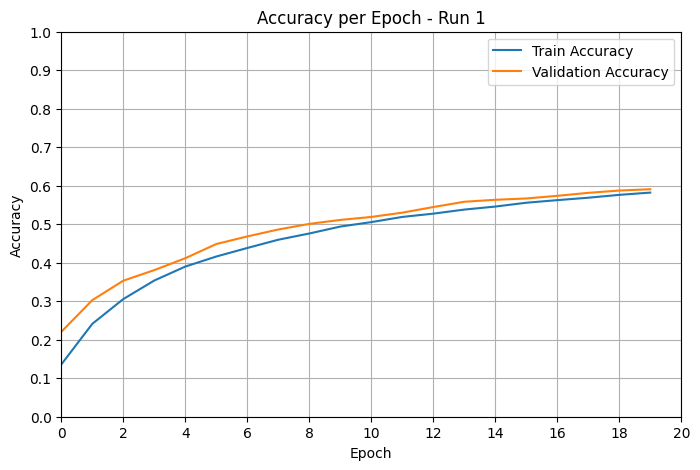

Test accuracy: 0.5909
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


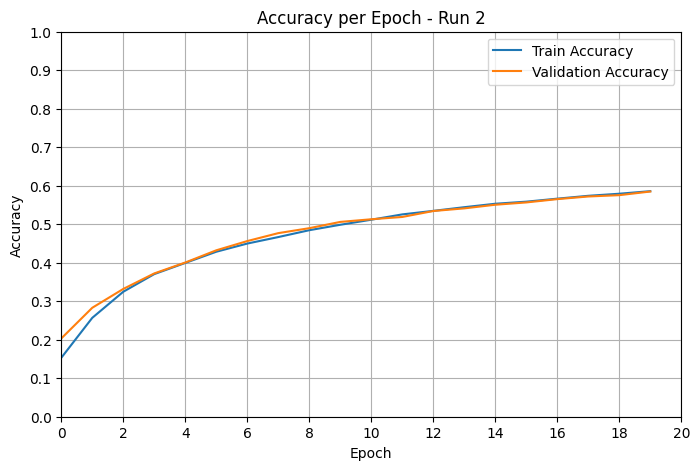

Test accuracy: 0.5849
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Run 3/5


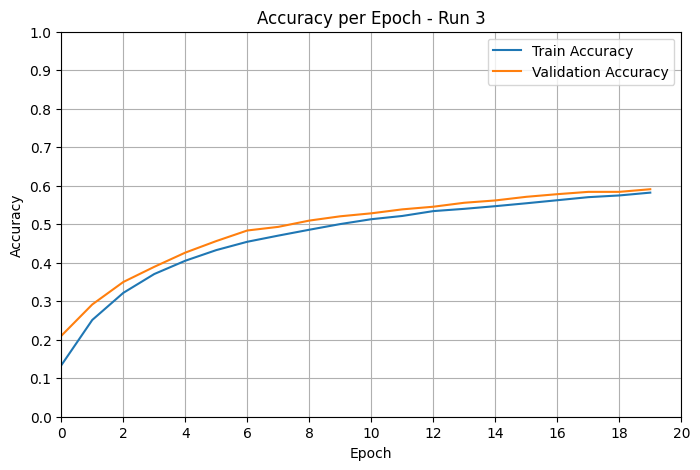

Test accuracy: 0.5909
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


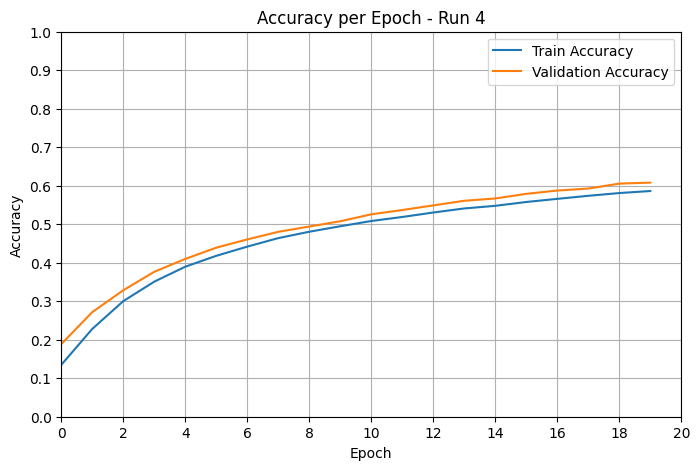

Test accuracy: 0.6081
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


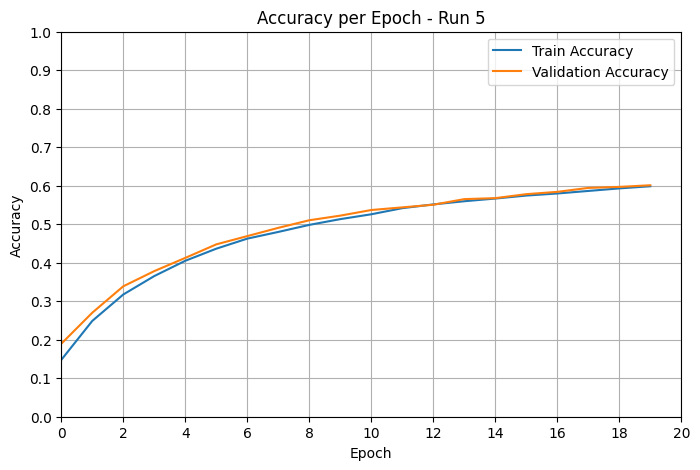

Test accuracy: 0.6012
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [512, 256], 'activation': 'sigmoid', 'loss': 'categorical_crossentropy'}
Run 1/5


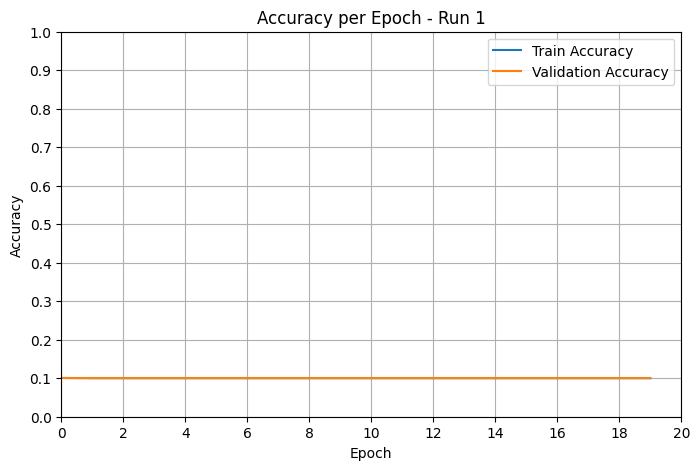

Test accuracy: 0.0995
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


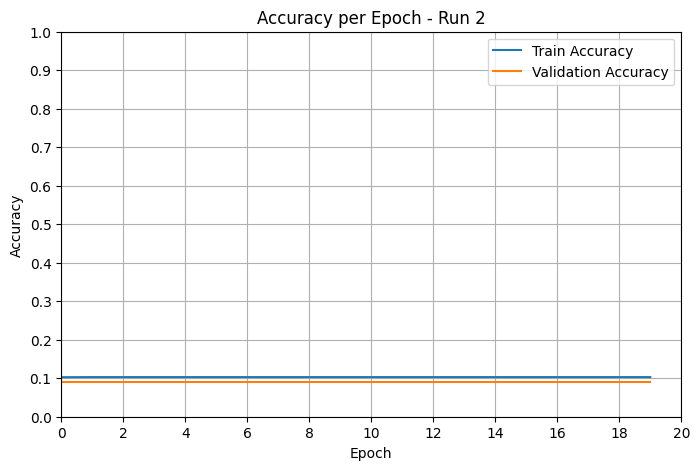

Test accuracy: 0.0892
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


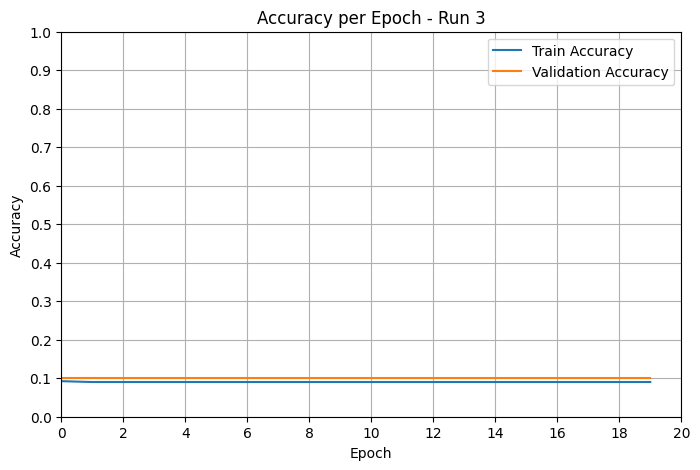

Test accuracy: 0.0995
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


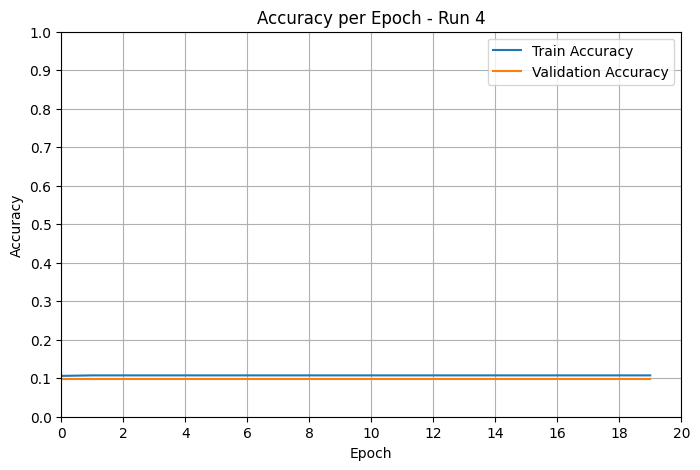

Test accuracy: 0.0969
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


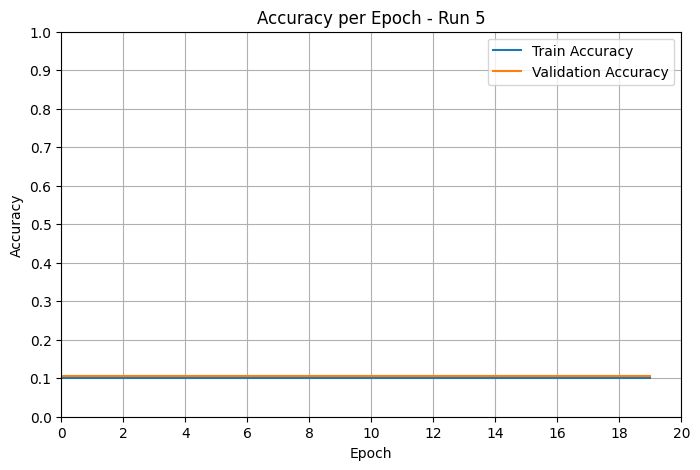

Test accuracy: 0.1046
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [512, 256], 'activation': 'sigmoid', 'loss': 'mean_squared_error'}
Run 1/5


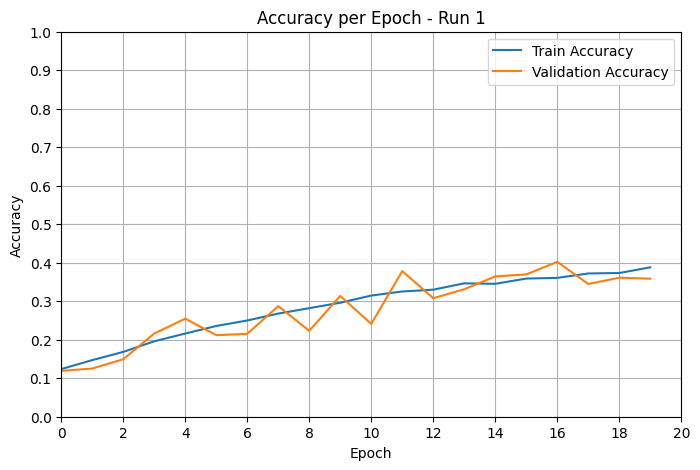

Test accuracy: 0.3585
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


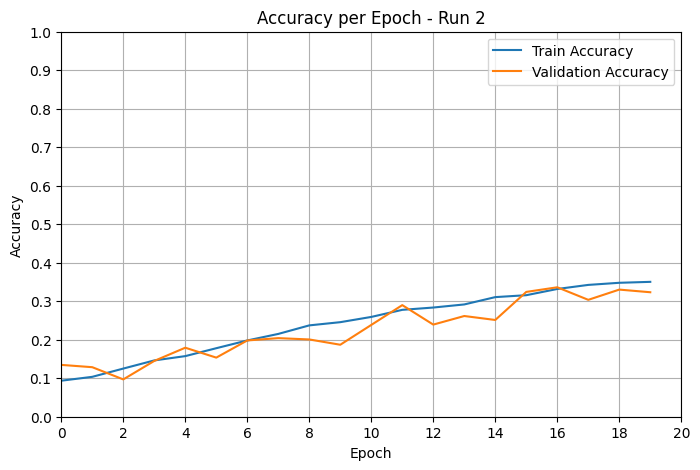

Test accuracy: 0.3233
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


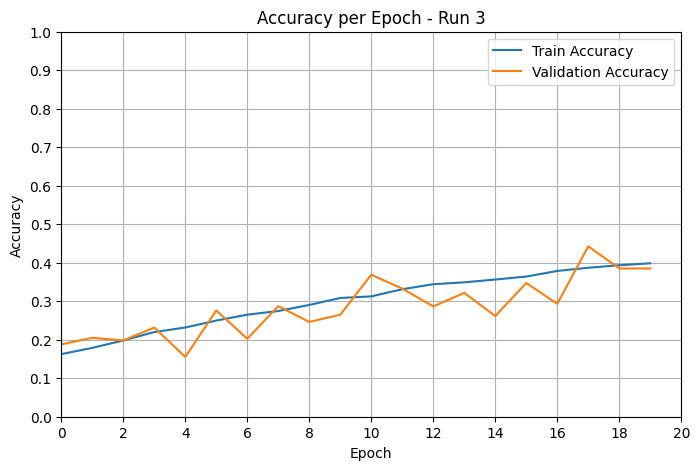

Test accuracy: 0.3851
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


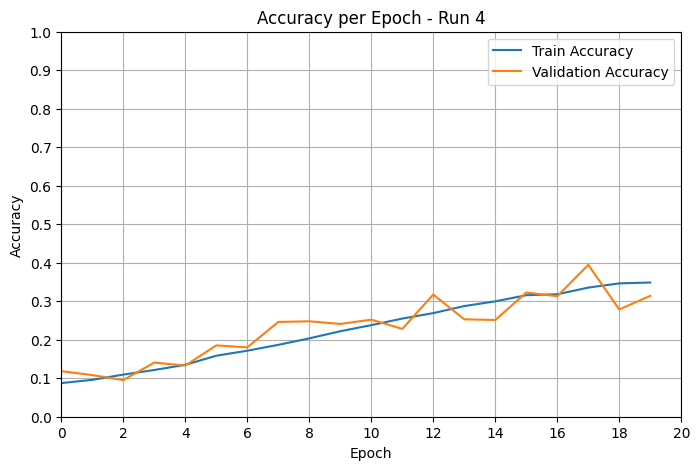

Test accuracy: 0.3139
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Run 5/5


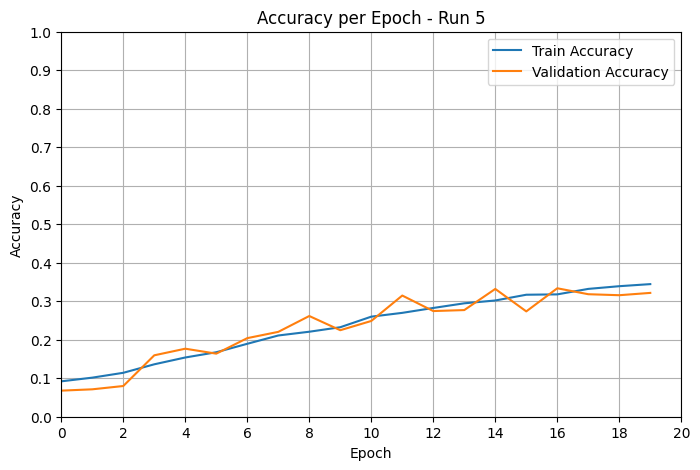

Test accuracy: 0.3216
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [512, 256], 'activation': 'tanh', 'loss': 'categorical_crossentropy'}
Run 1/5


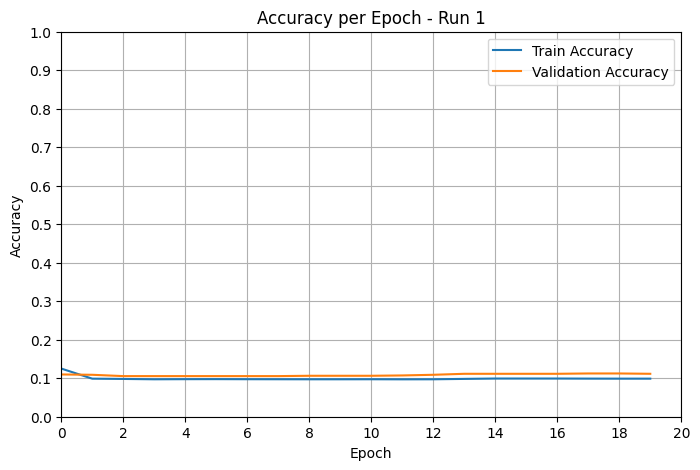

Test accuracy: 0.1115
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


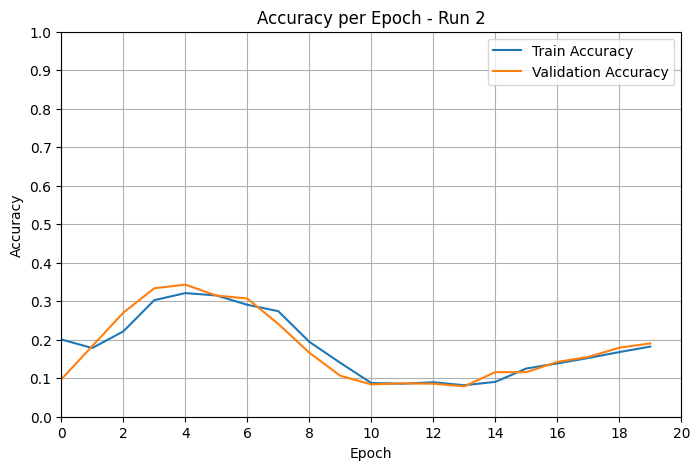

Test accuracy: 0.1904
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


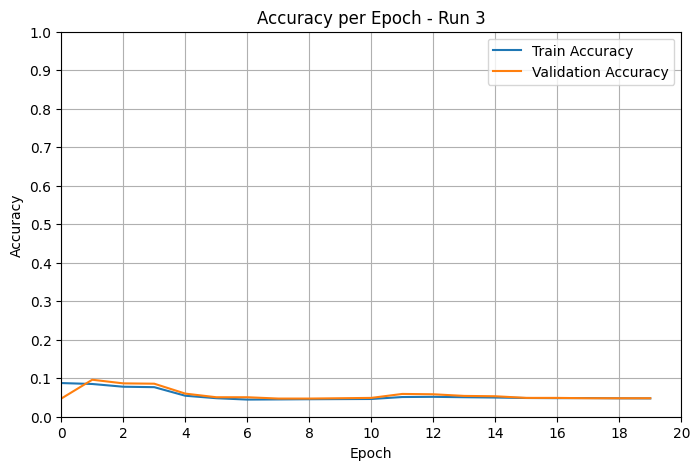

Test accuracy: 0.0480
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


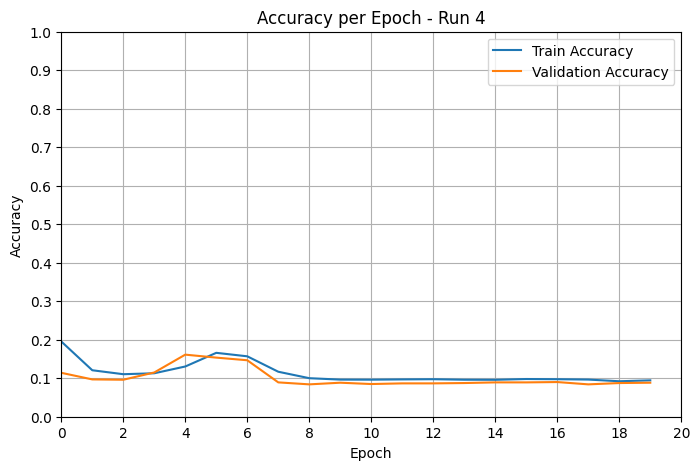

Test accuracy: 0.0883
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


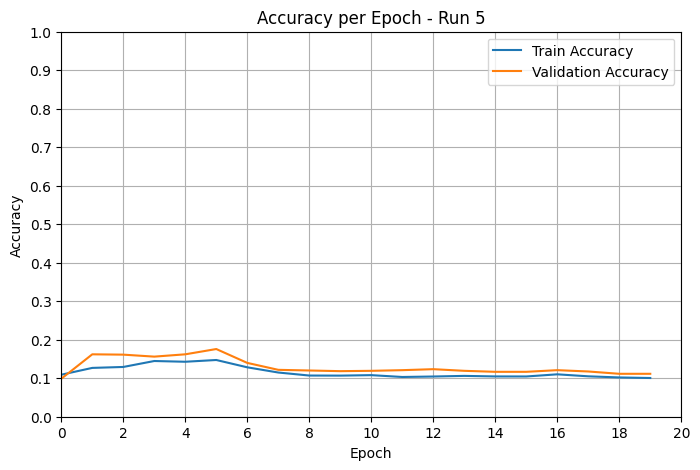

Test accuracy: 0.1115
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [512, 256], 'activation': 'tanh', 'loss': 'mean_squared_error'}
Run 1/5


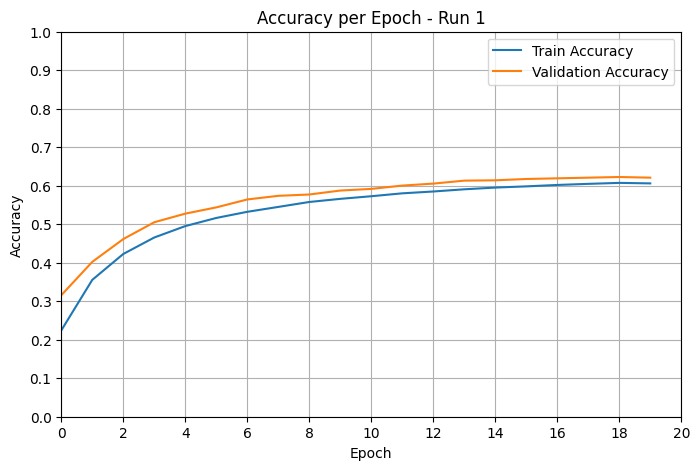

Test accuracy: 0.6209
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


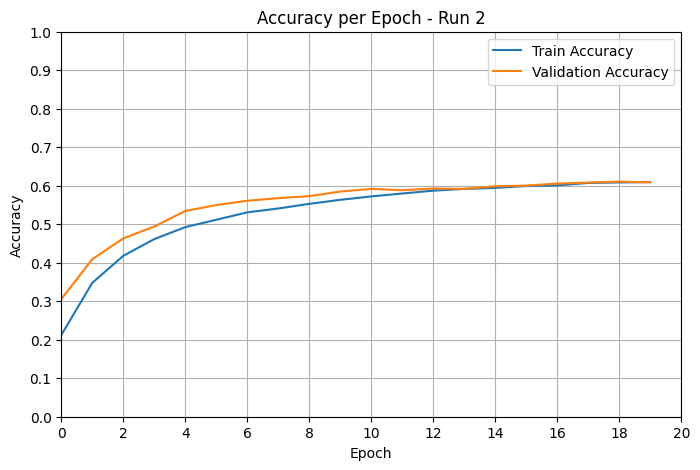

Test accuracy: 0.6089
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


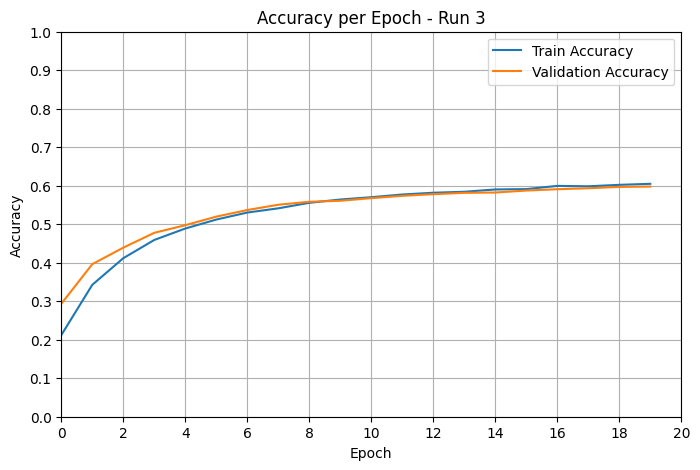

Test accuracy: 0.5978
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


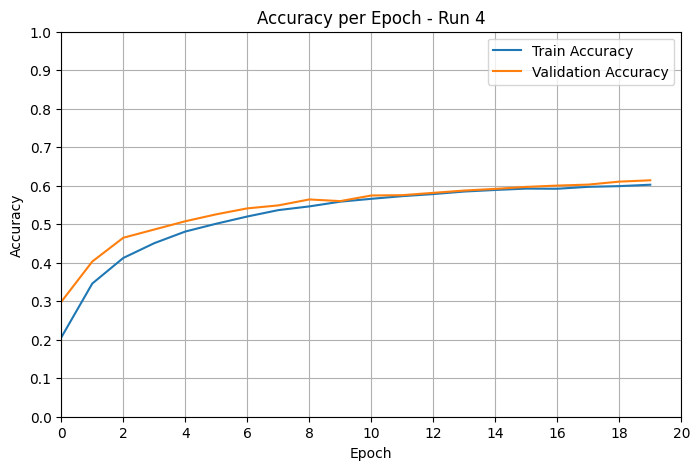

Test accuracy: 0.6141
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


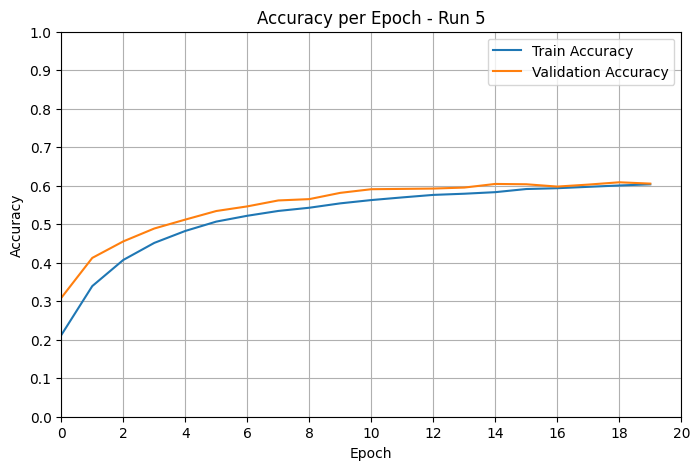

Test accuracy: 0.6055
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [1024, 512, 128], 'activation': 'relu', 'loss': 'categorical_crossentropy'}
Run 1/5


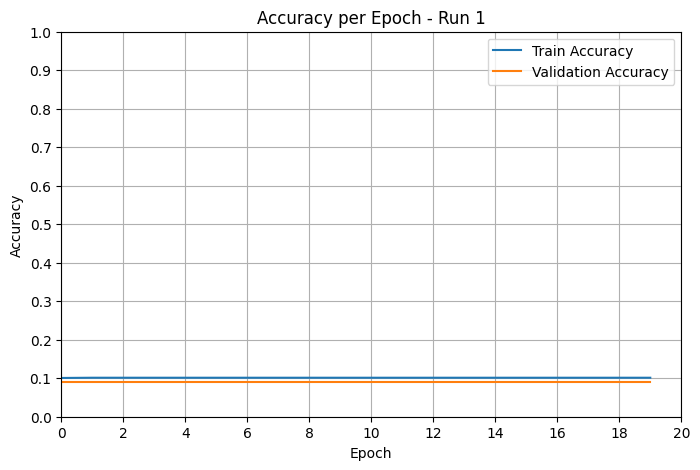

Test accuracy: 0.0901
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


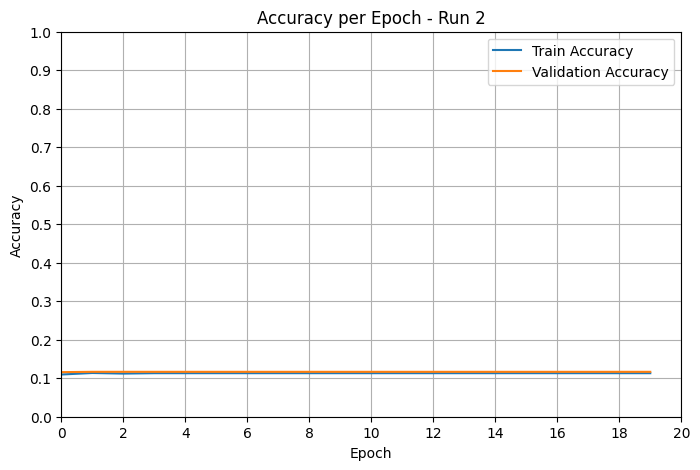

Test accuracy: 0.1166
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


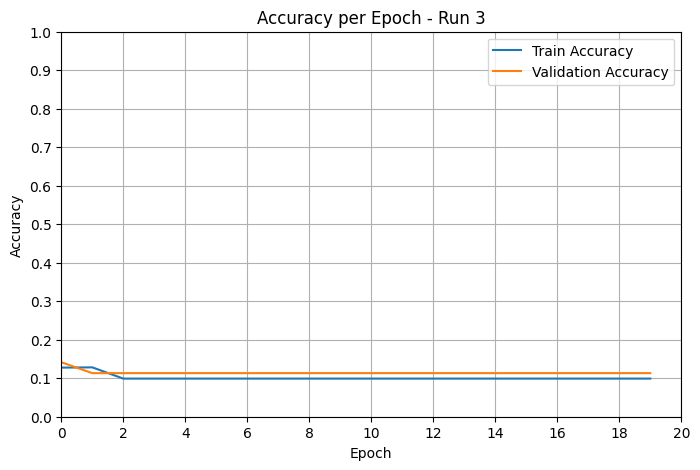

Test accuracy: 0.1132
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


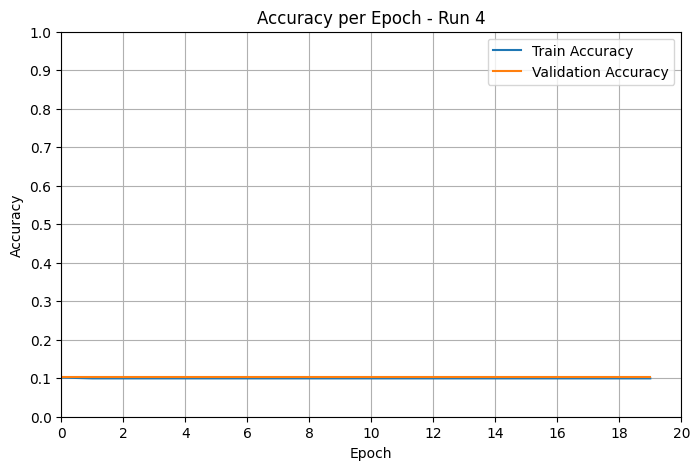

Test accuracy: 0.1038
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


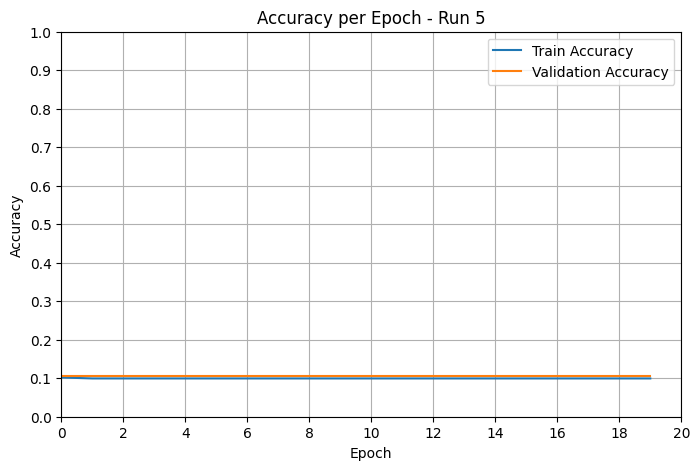

Test accuracy: 0.1046
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [1024, 512, 128], 'activation': 'relu', 'loss': 'mean_squared_error'}
Run 1/5


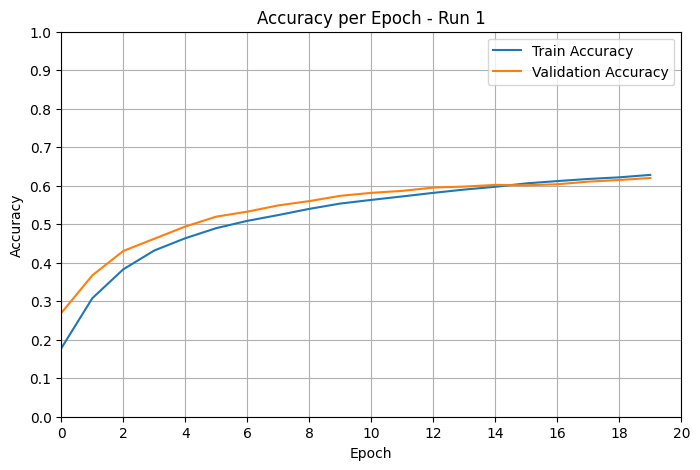

Test accuracy: 0.6201
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


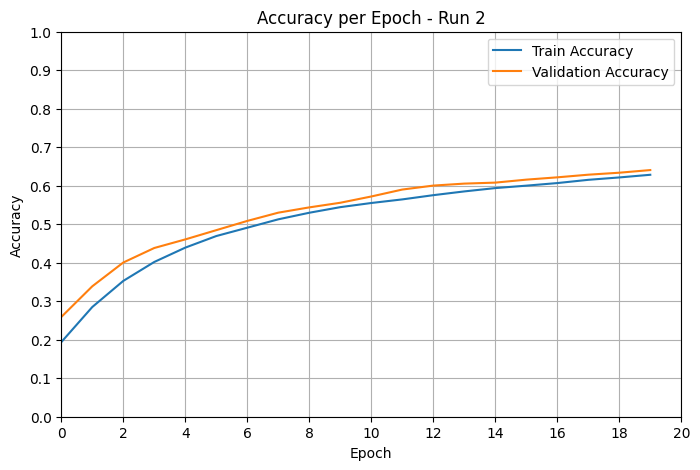

Test accuracy: 0.6407
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


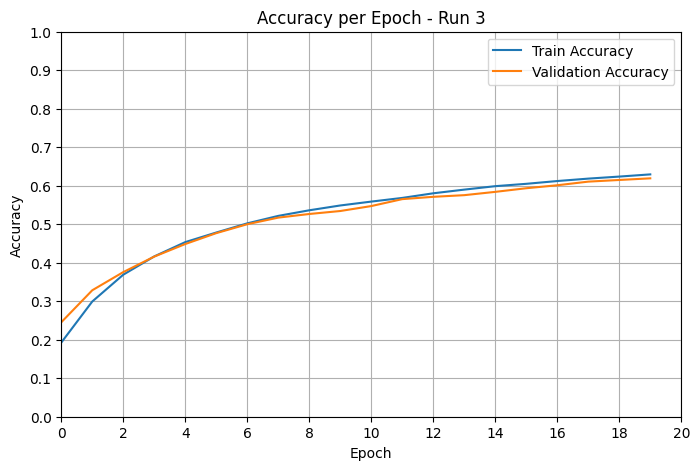

Test accuracy: 0.6192
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


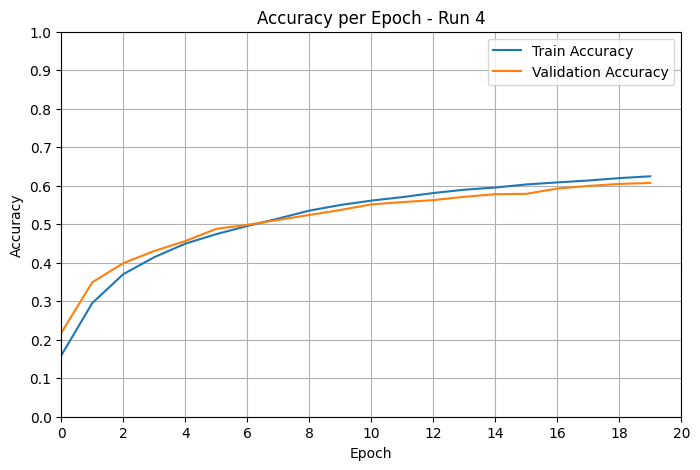

Test accuracy: 0.6072
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


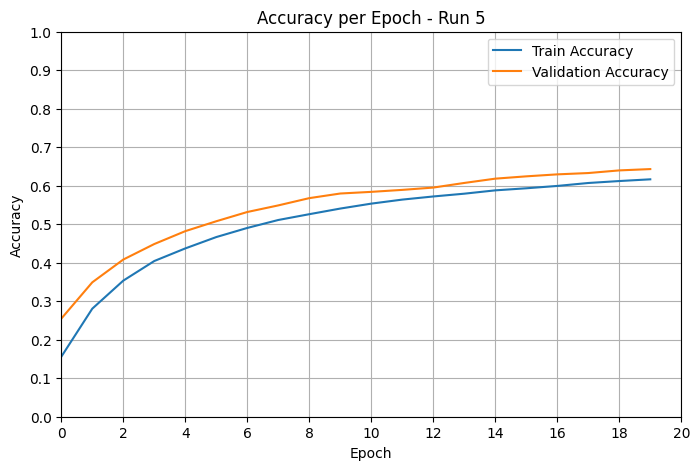

Test accuracy: 0.6432
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [1024, 512, 128], 'activation': 'sigmoid', 'loss': 'categorical_crossentropy'}
Run 1/5


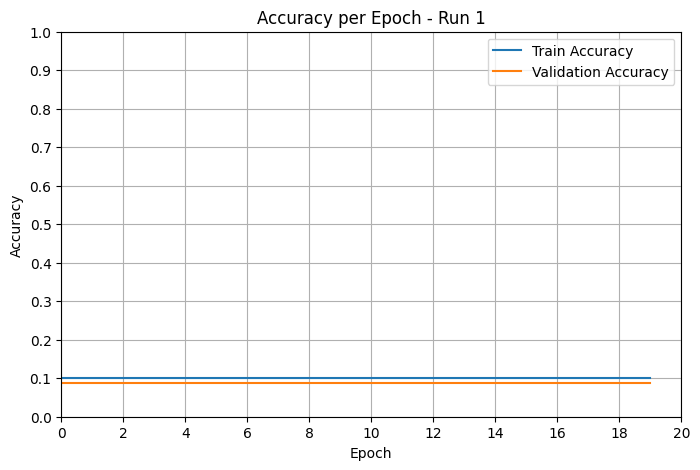

Test accuracy: 0.0883
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


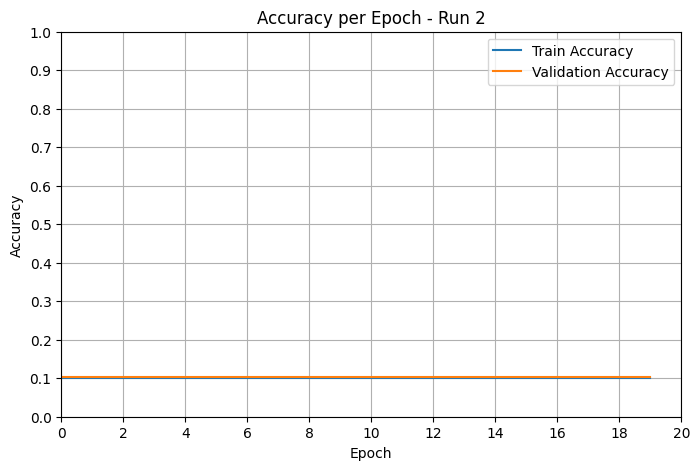

Test accuracy: 0.1038
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


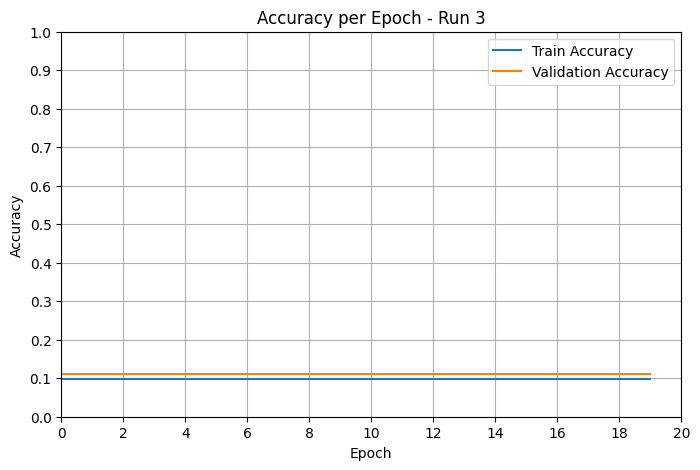

Test accuracy: 0.1115
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


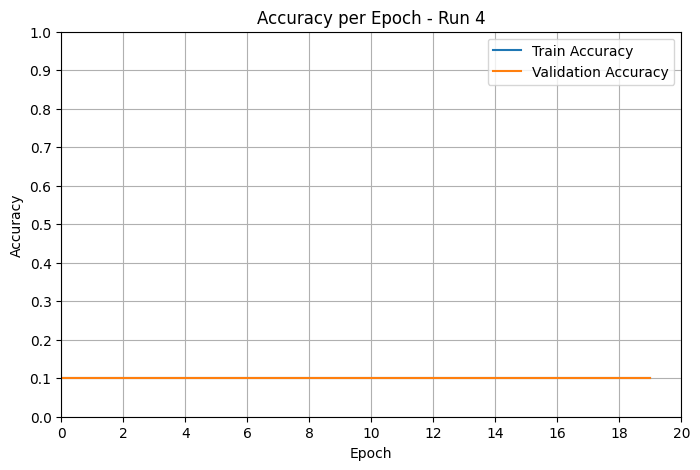

Test accuracy: 0.0995
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


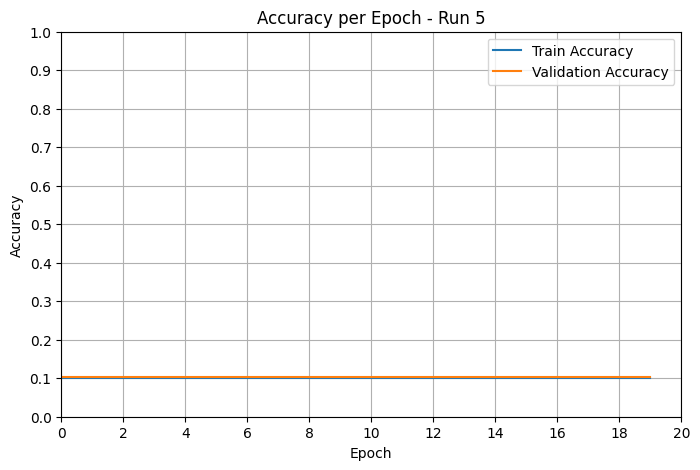

Test accuracy: 0.1029
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [1024, 512, 128], 'activation': 'sigmoid', 'loss': 'mean_squared_error'}
Run 1/5


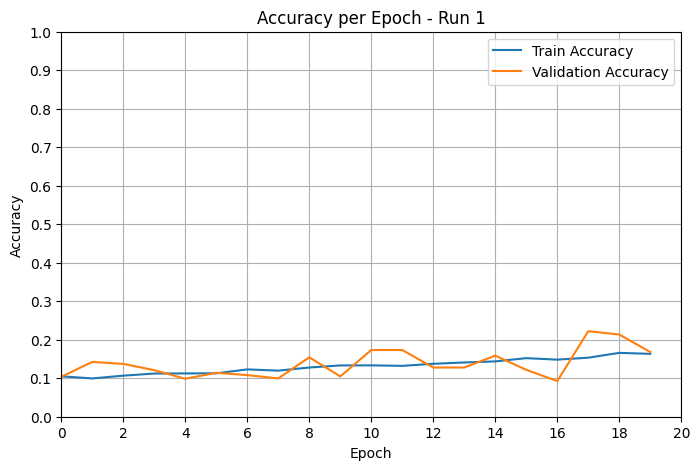

Test accuracy: 0.1681
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


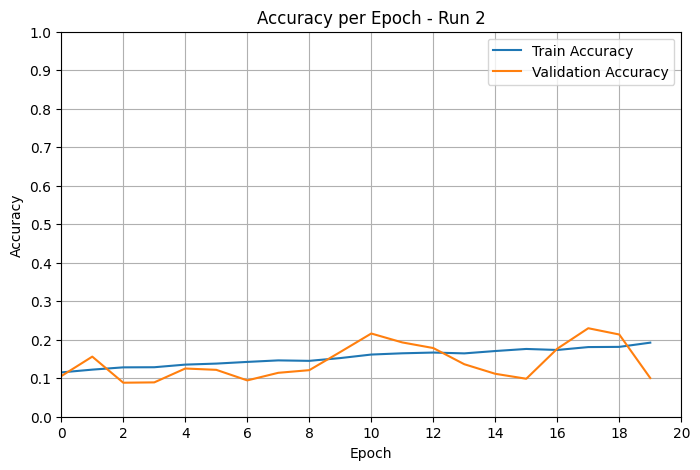

Test accuracy: 0.1003
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


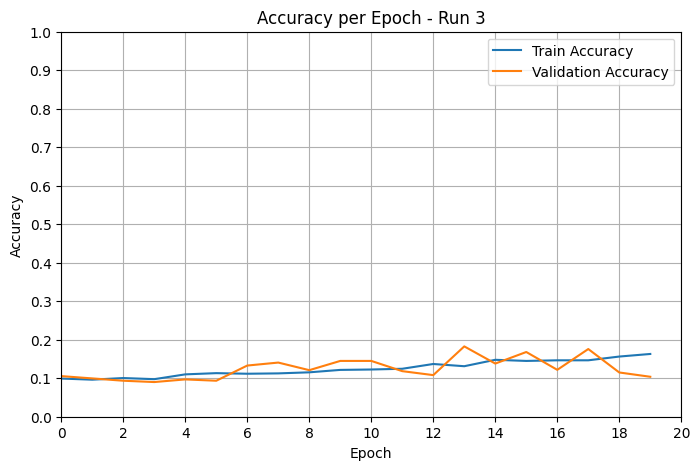

Test accuracy: 0.1038
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


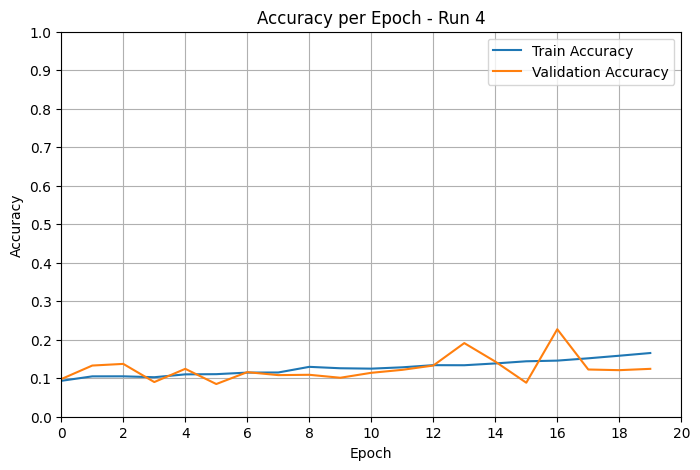

Test accuracy: 0.1244
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


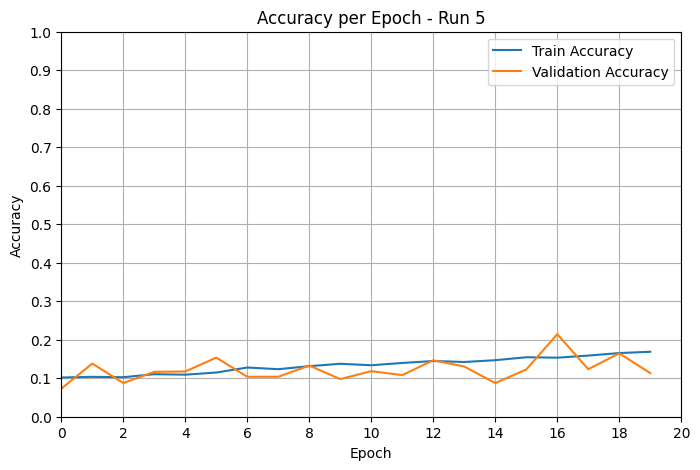

Test accuracy: 0.1132
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [1024, 512, 128], 'activation': 'tanh', 'loss': 'categorical_crossentropy'}
Run 1/5


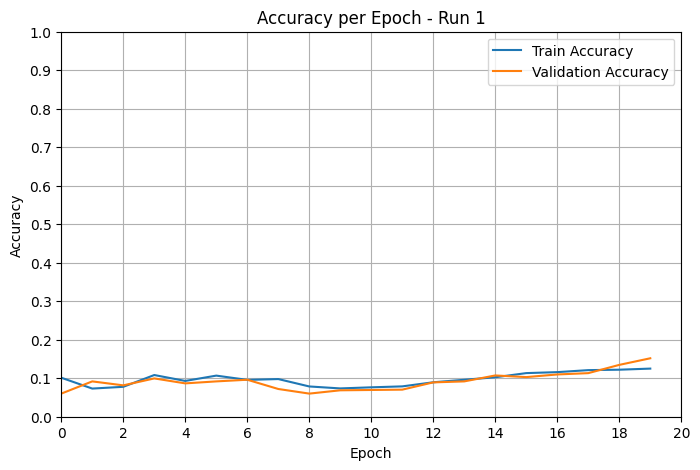

Test accuracy: 0.1518
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


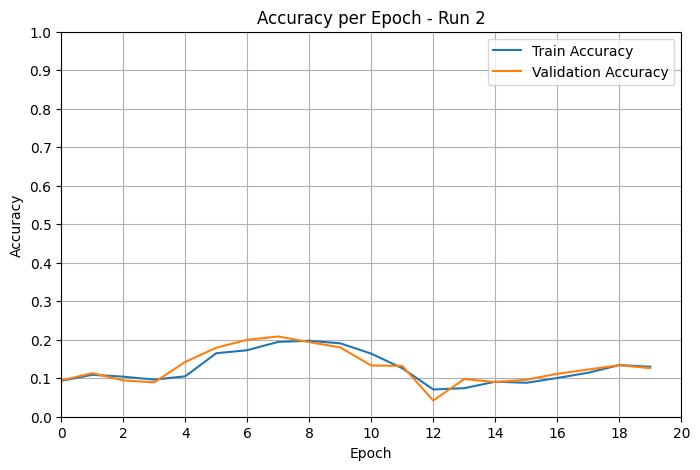

Test accuracy: 0.1261
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


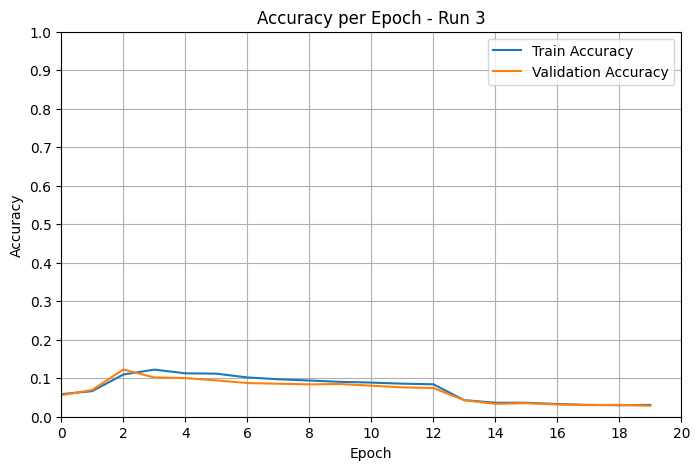

Test accuracy: 0.0283
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


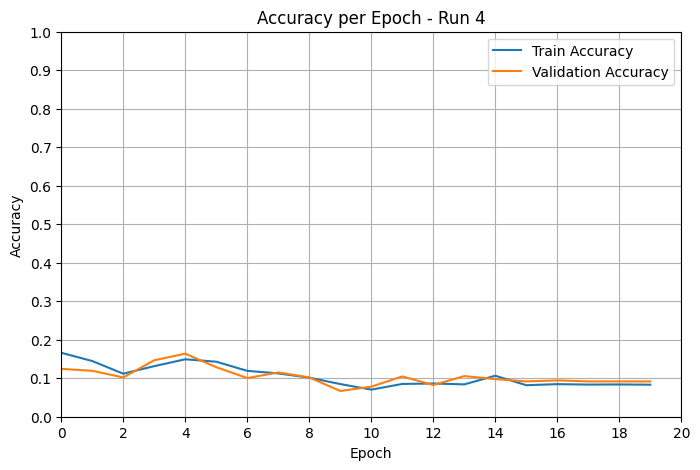

Test accuracy: 0.0918
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


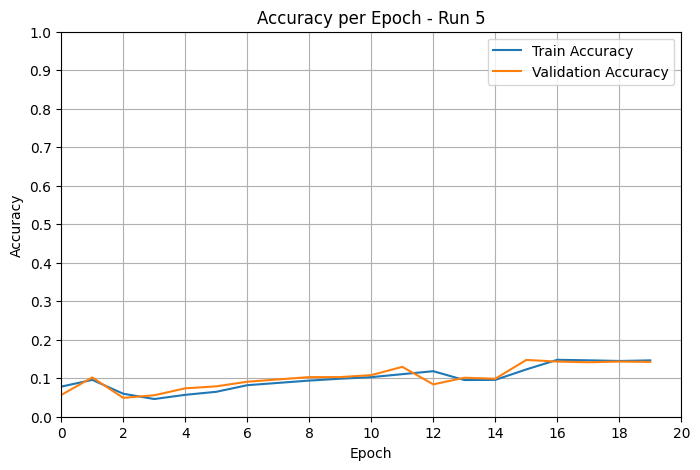

Test accuracy: 0.1424
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [1024, 512, 128], 'activation': 'tanh', 'loss': 'mean_squared_error'}
Run 1/5


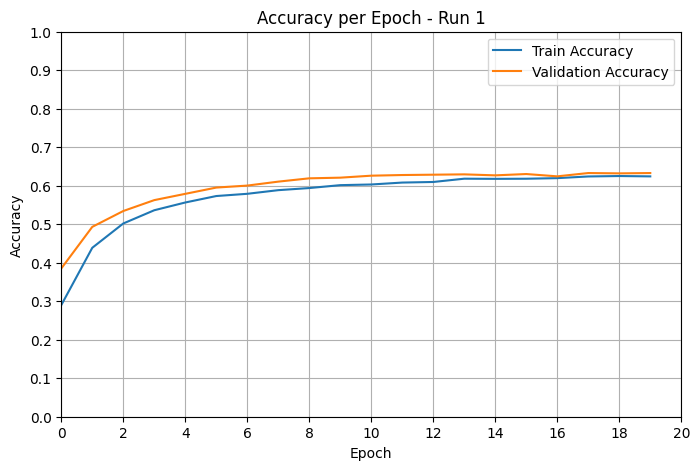

Test accuracy: 0.6329
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 2/5


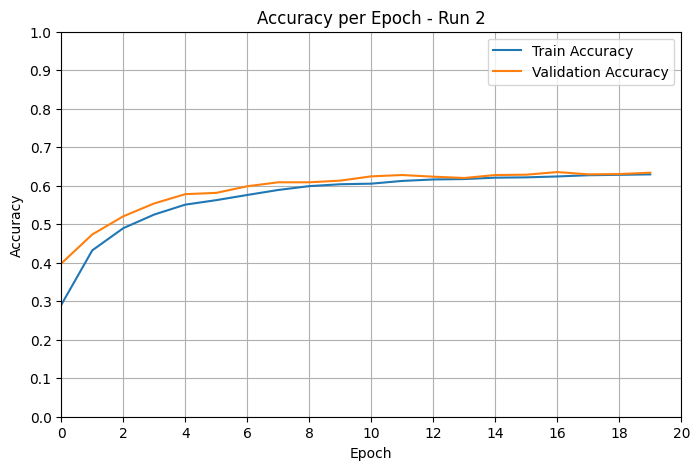

Test accuracy: 0.6338
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


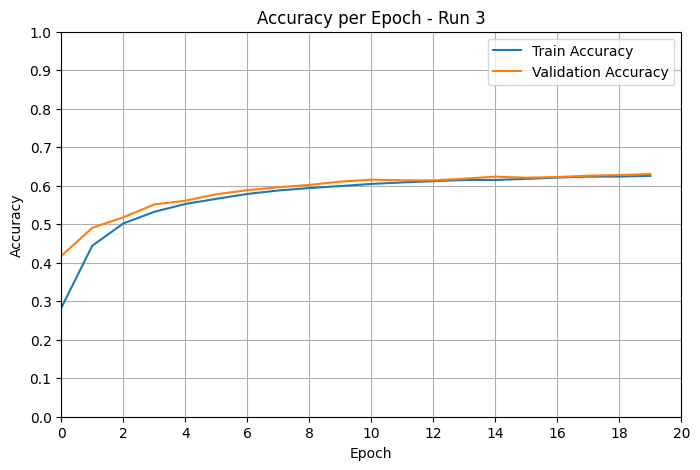

Test accuracy: 0.6304
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


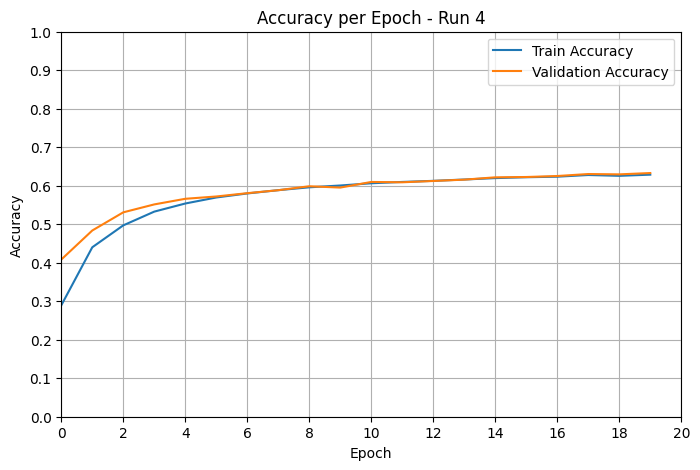

Test accuracy: 0.6329
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


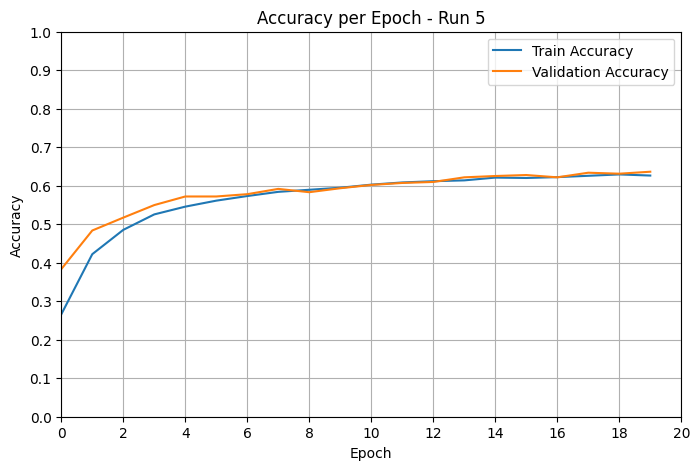

Test accuracy: 0.6364
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [256, 128, 64, 32], 'activation': 'relu', 'loss': 'categorical_crossentropy'}
Run 1/5


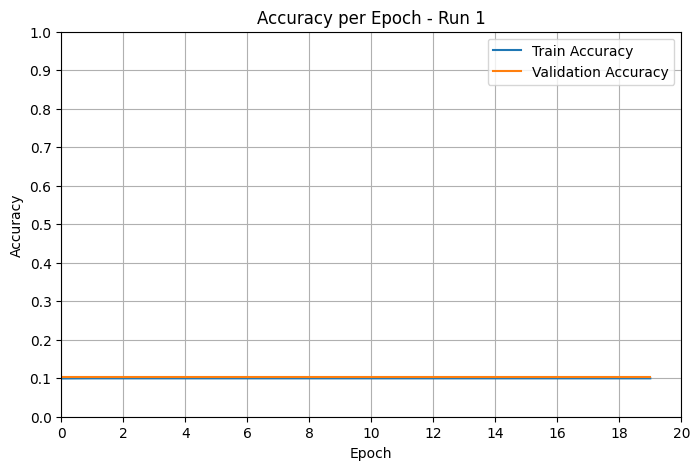

Test accuracy: 0.1029
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


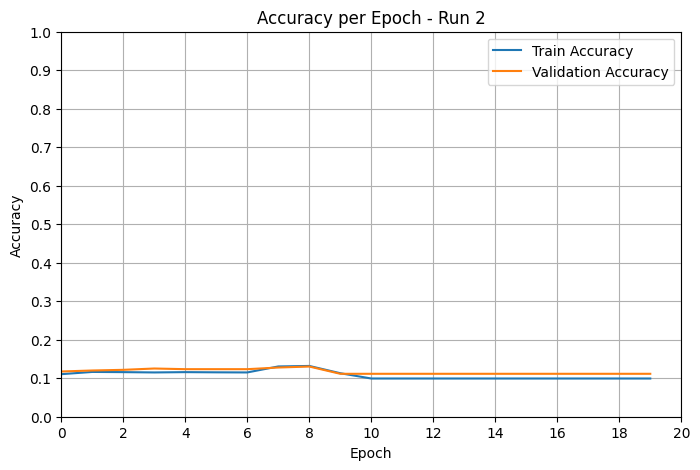

Test accuracy: 0.1115
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


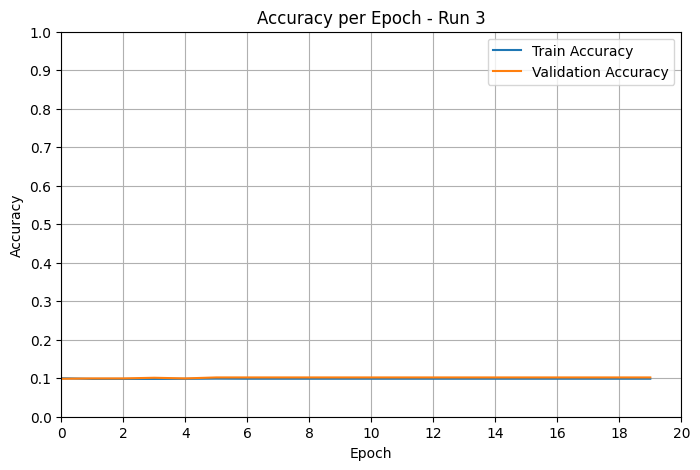

Test accuracy: 0.1021
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


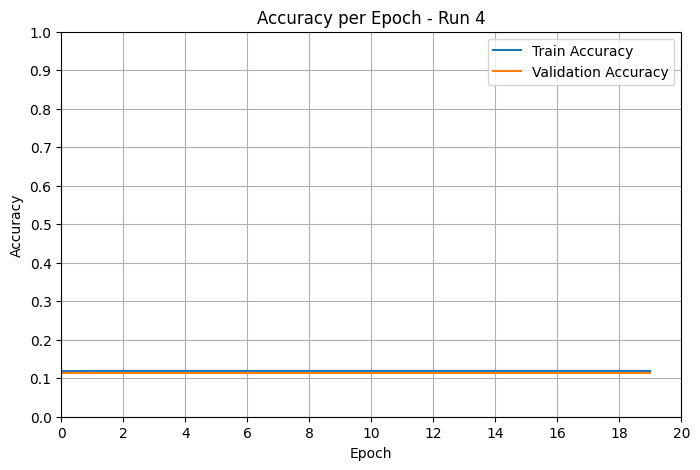

Test accuracy: 0.1123
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


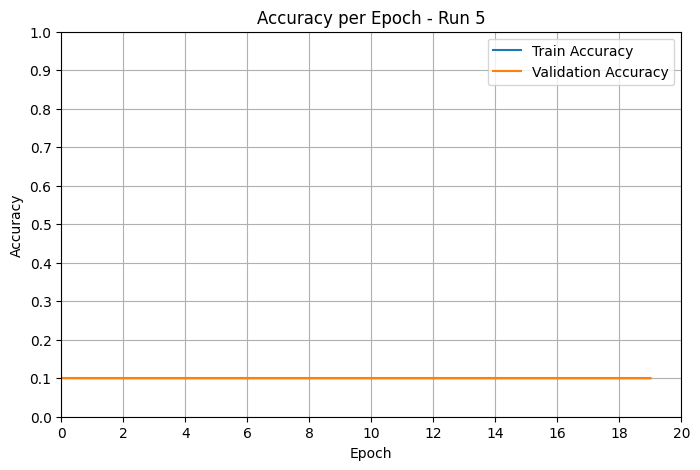

Test accuracy: 0.0995
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [256, 128, 64, 32], 'activation': 'relu', 'loss': 'mean_squared_error'}
Run 1/5


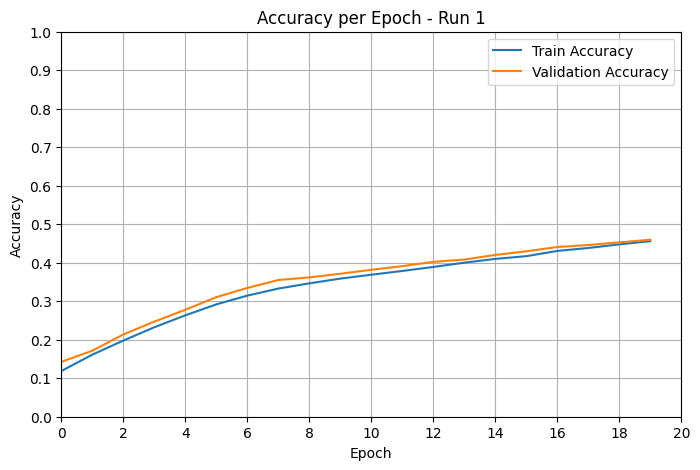

Test accuracy: 0.4597
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


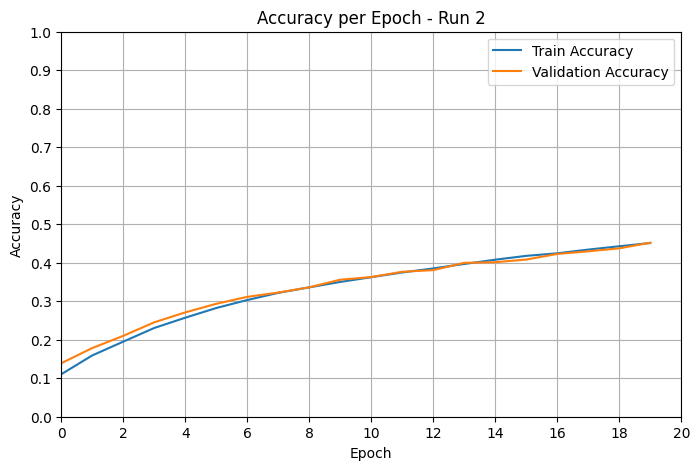

Test accuracy: 0.4520
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


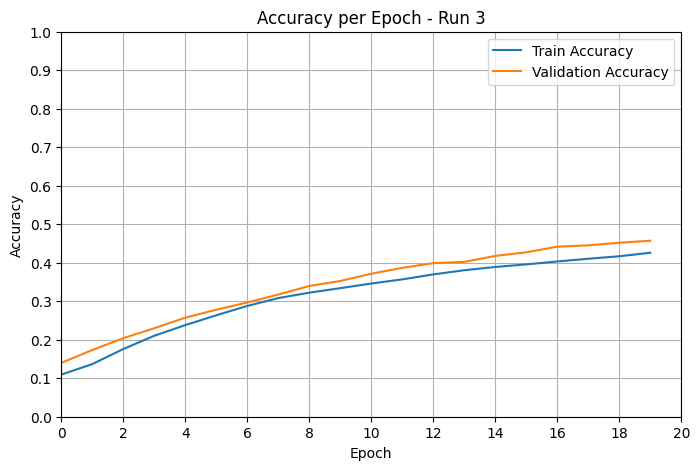

Test accuracy: 0.4571
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


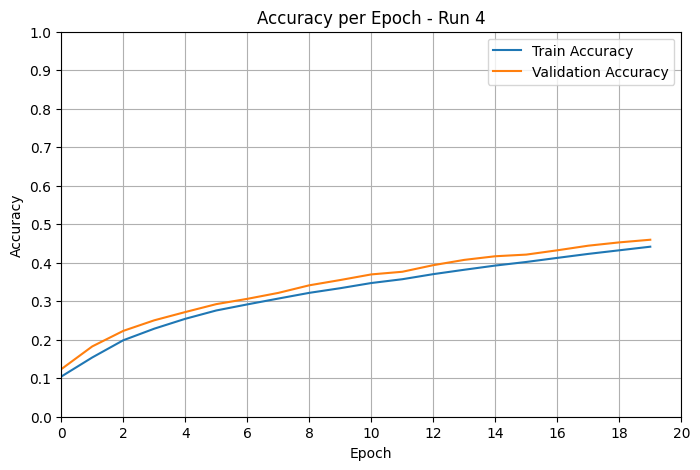

Test accuracy: 0.4597
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


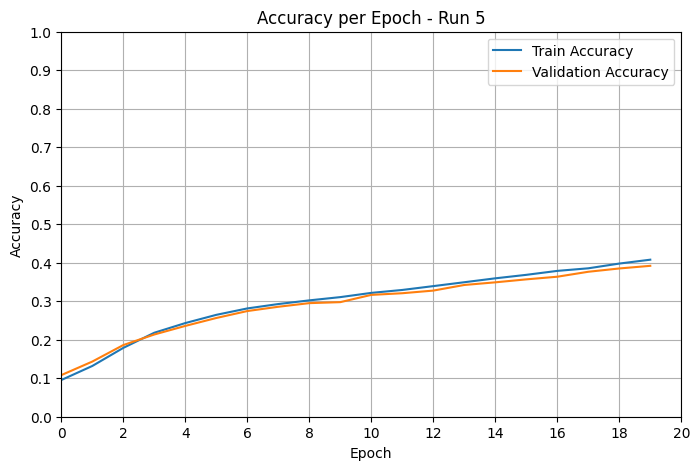

Test accuracy: 0.3919
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [256, 128, 64, 32], 'activation': 'sigmoid', 'loss': 'categorical_crossentropy'}
Run 1/5


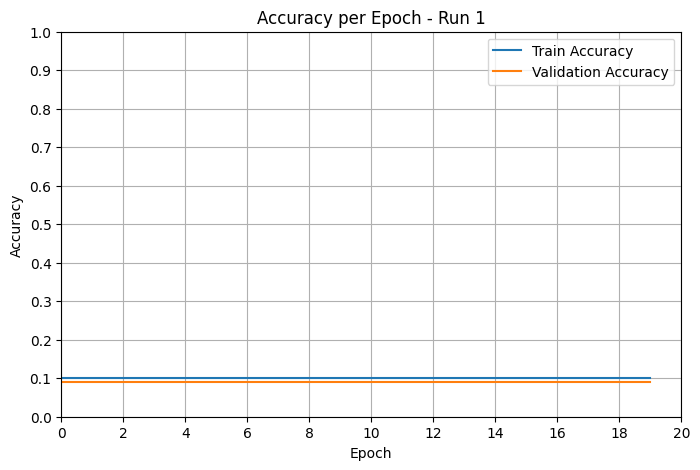

Test accuracy: 0.0901
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


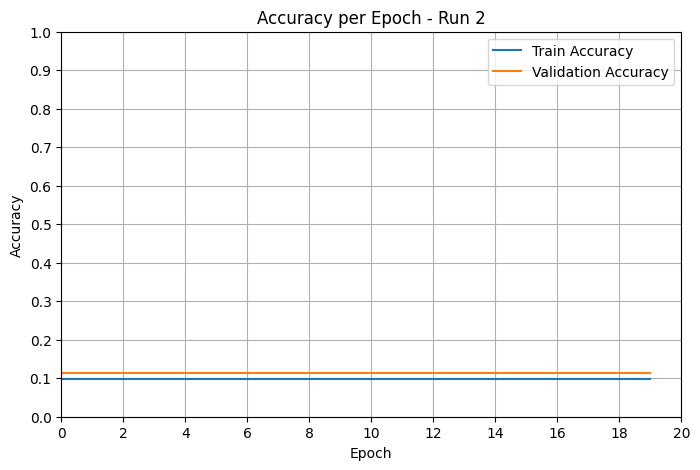

Test accuracy: 0.1123
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


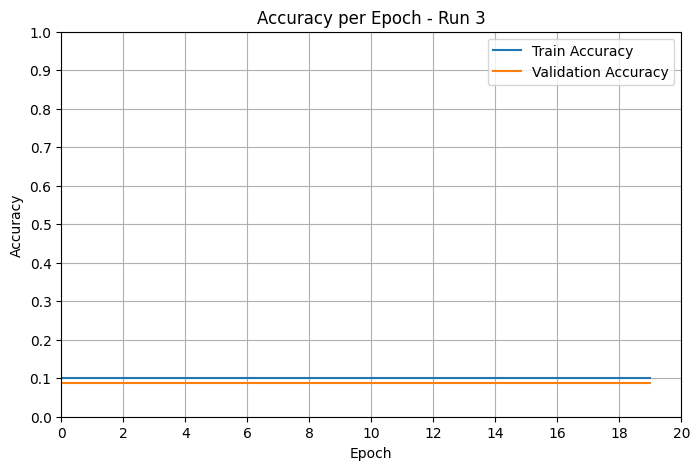

Test accuracy: 0.0875
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


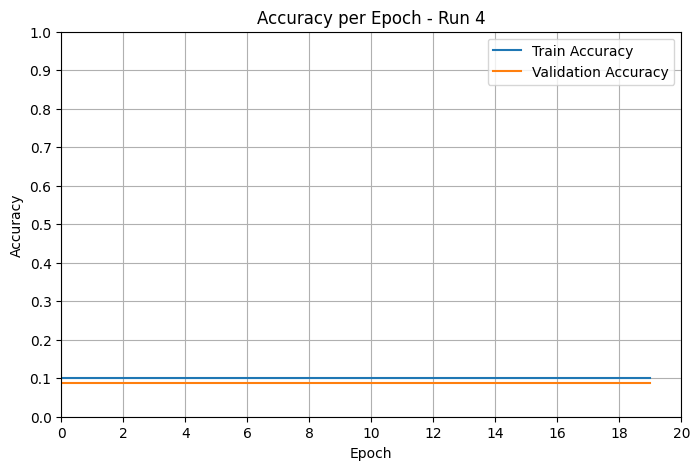

Test accuracy: 0.0875
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


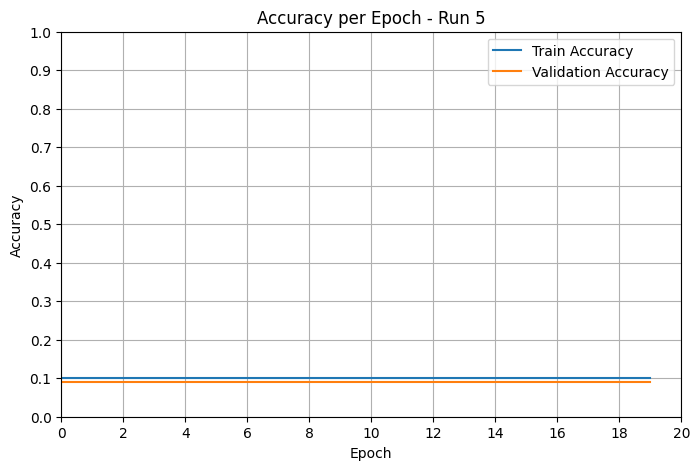

Test accuracy: 0.0901
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [256, 128, 64, 32], 'activation': 'sigmoid', 'loss': 'mean_squared_error'}
Run 1/5


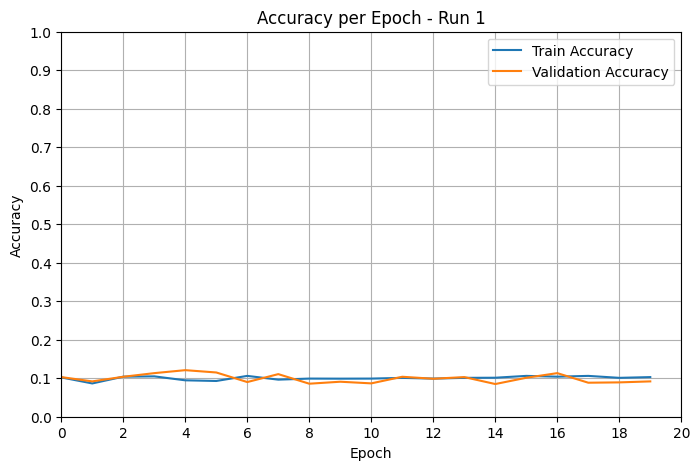

Test accuracy: 0.0918
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


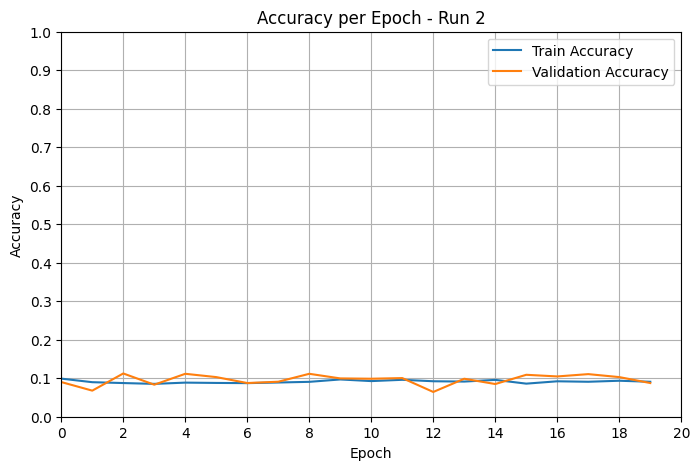

Test accuracy: 0.0875
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


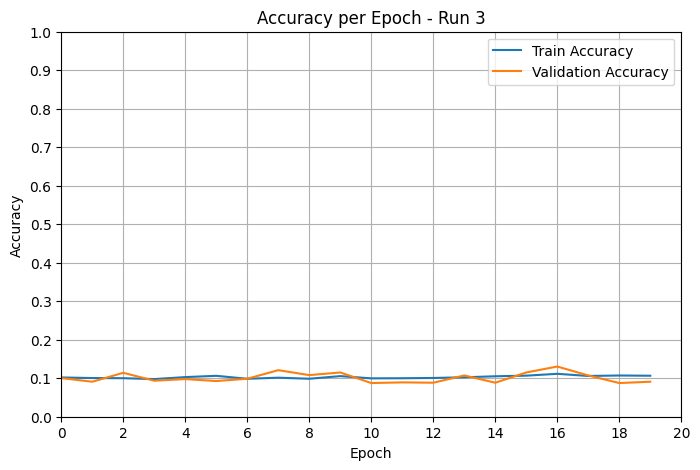

Test accuracy: 0.0909
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


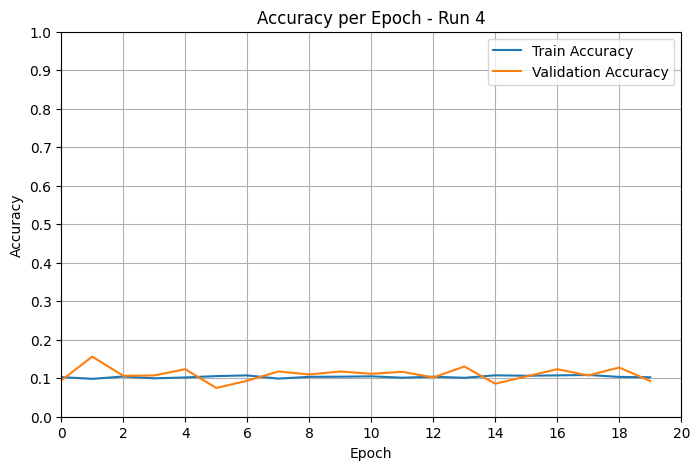

Test accuracy: 0.0926
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


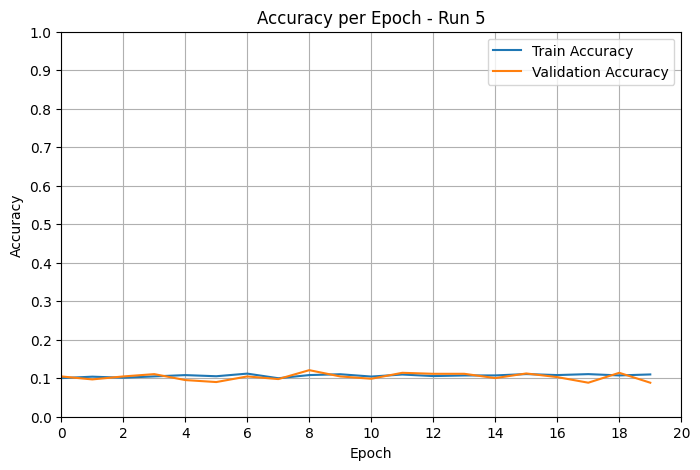

Test accuracy: 0.0883
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [256, 128, 64, 32], 'activation': 'tanh', 'loss': 'categorical_crossentropy'}
Run 1/5


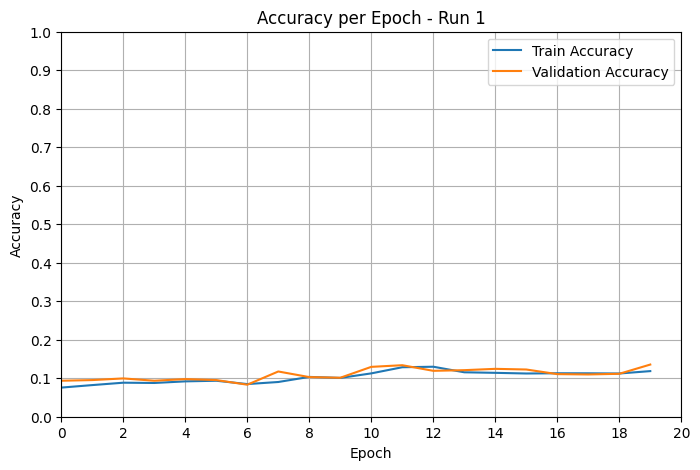

Test accuracy: 0.1355
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


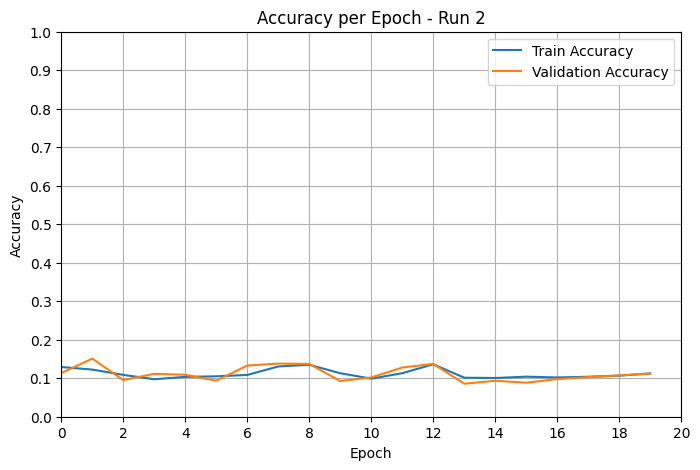

Test accuracy: 0.1123
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


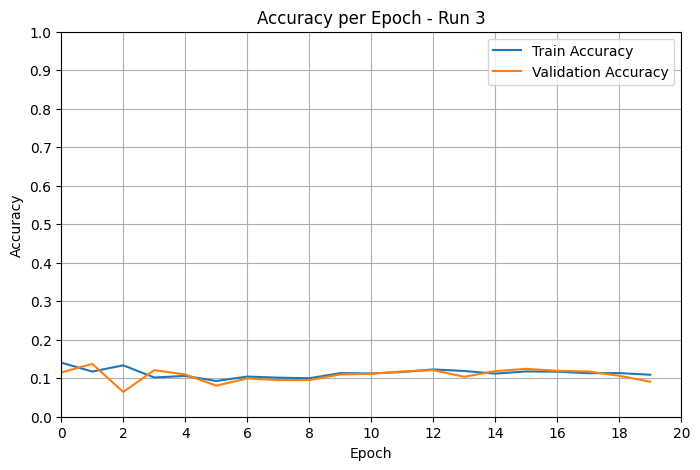

Test accuracy: 0.0909
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


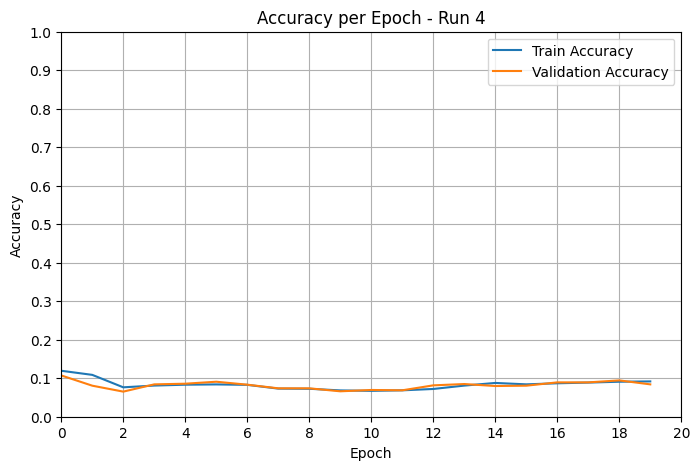

Test accuracy: 0.0840
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


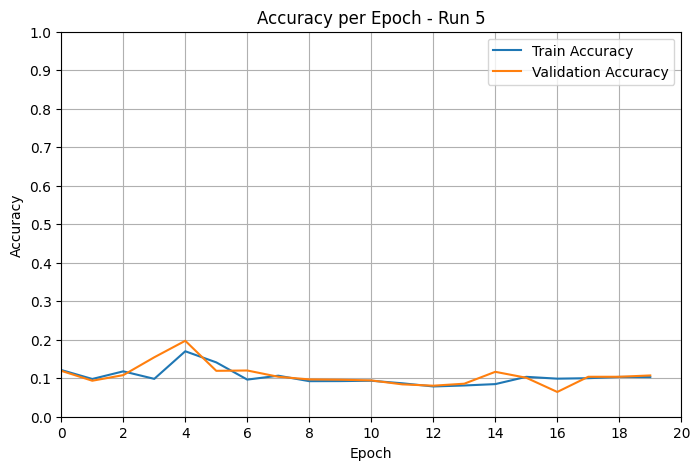

Test accuracy: 0.1072
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training with config: {'layer_sizes': [256, 128, 64, 32], 'activation': 'tanh', 'loss': 'mean_squared_error'}
Run 1/5


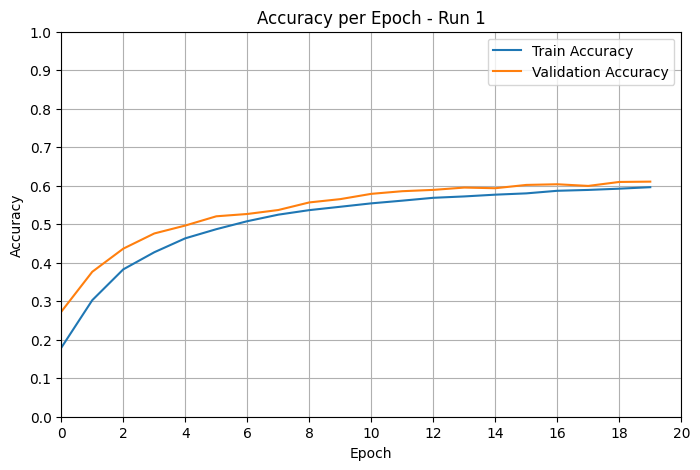

Test accuracy: 0.6106
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


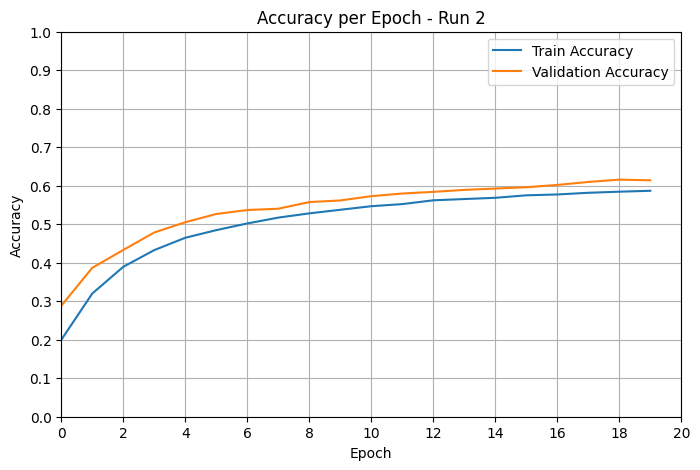

Test accuracy: 0.6141
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


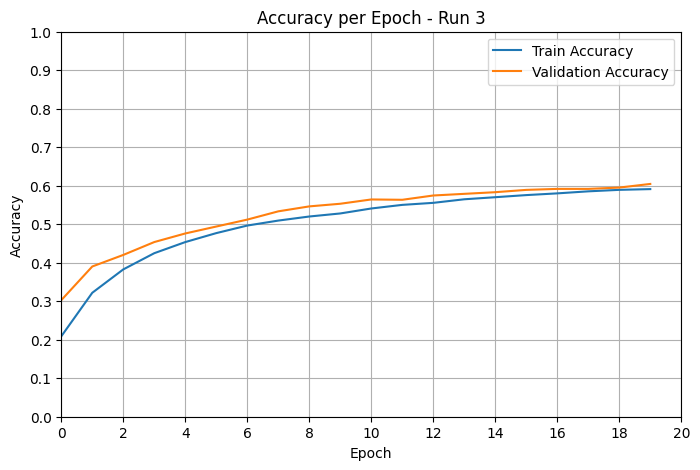

Test accuracy: 0.6046
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


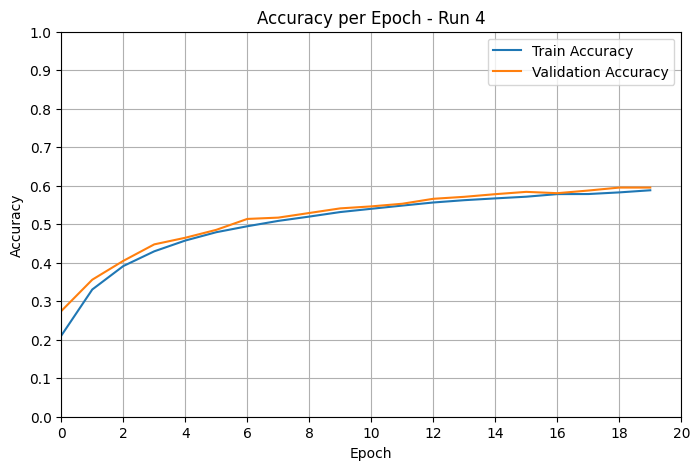

Test accuracy: 0.5952
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


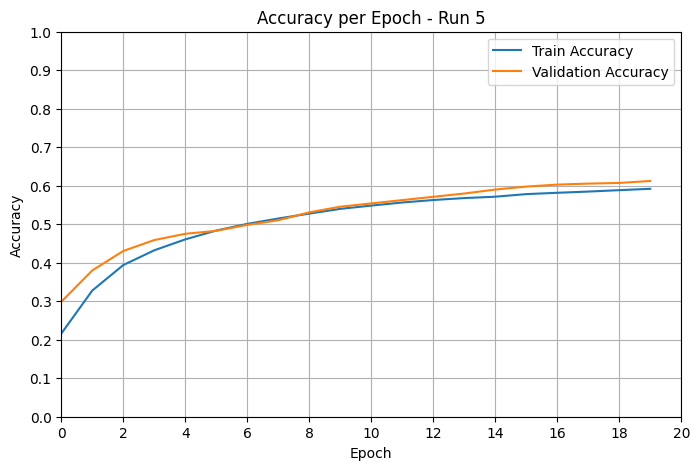

Test accuracy: 0.6123
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [40]:
layer_sizes_options = [
    [512, 256],
    [1024, 512, 128],
    [256, 128, 64, 32]
]
activations = ['relu', 'sigmoid', 'tanh']
losses = ['categorical_crossentropy', 'mean_squared_error']

results = {}

for layers, act, loss in product(layer_sizes_options, activations, losses):
    config = {"layer_sizes": layers, "activation": act, "loss": loss}
    print(f"Training with config: {config}")
    builder = create_builder(config, num_classes)
    res = train_and_evaluate(builder, X_train_pca, y_train_onehot, X_test_pca, y_test_onehot, runs=5)
    key = f"layers={layers}_act={act}_loss={loss}"
    results[key] = res

Training model MLP1 with config: {'layer_sizes': [1024, 512, 64], 'activation': 'relu', 'loss': 'mean_squared_error'}
Run 1/5


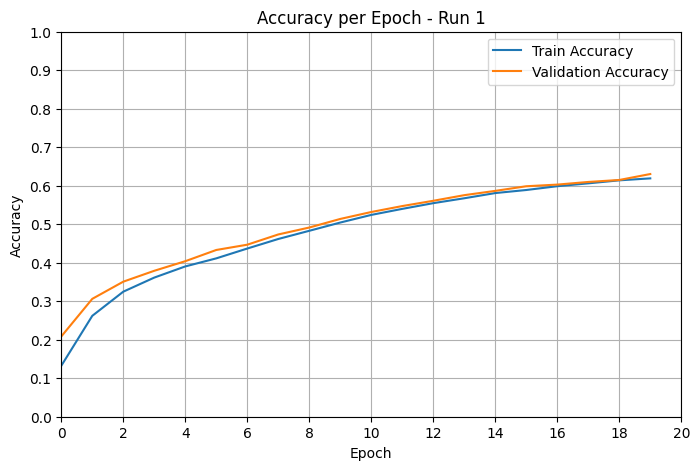

Test accuracy: 0.6304
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


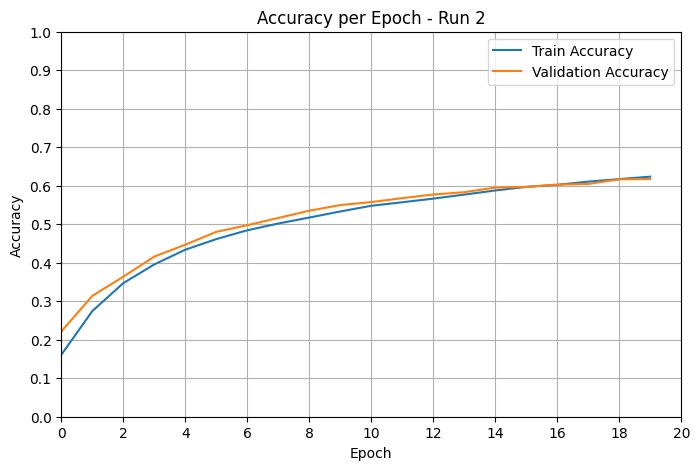

Test accuracy: 0.6175
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


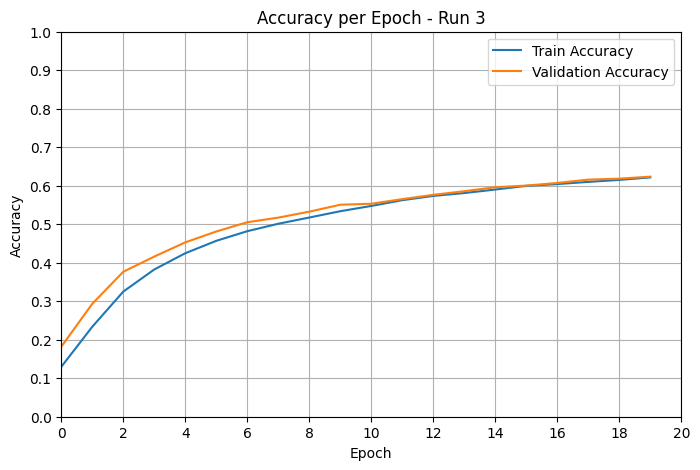

Test accuracy: 0.6235
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


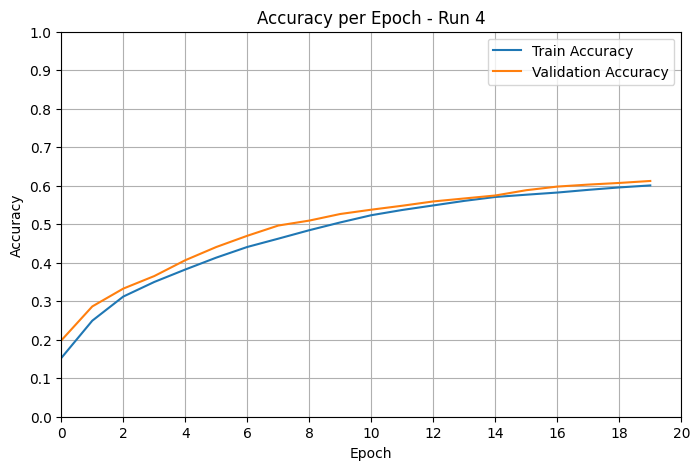

Test accuracy: 0.6123
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


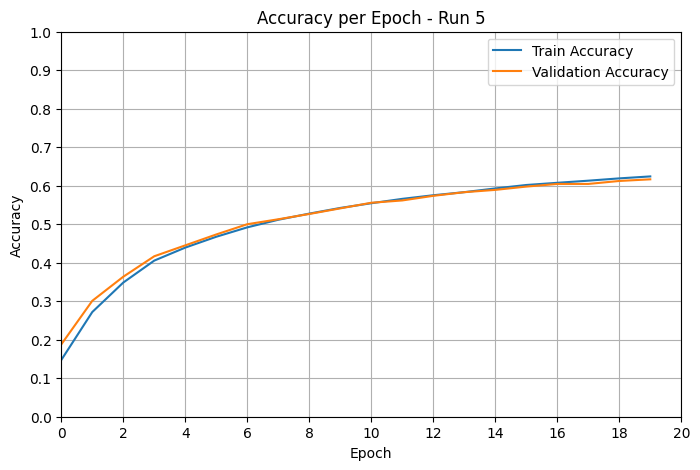

Test accuracy: 0.6166
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training model MLP2 with config: {'layer_sizes': [1024, 512, 64], 'activation': 'tanh', 'loss': 'mean_squared_error'}
Run 1/5


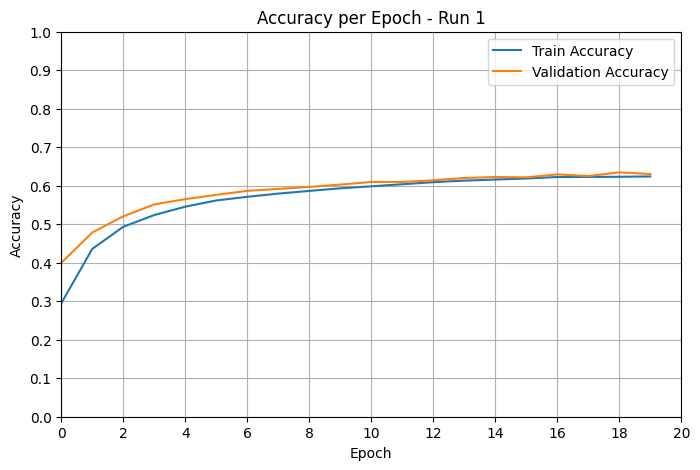

Test accuracy: 0.6304
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


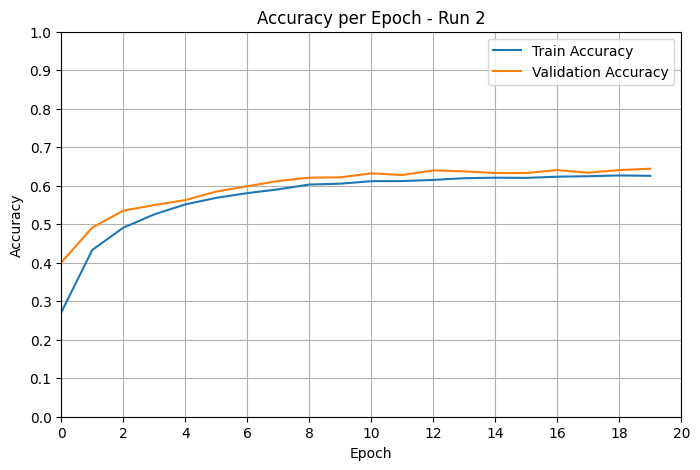

Test accuracy: 0.6441
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


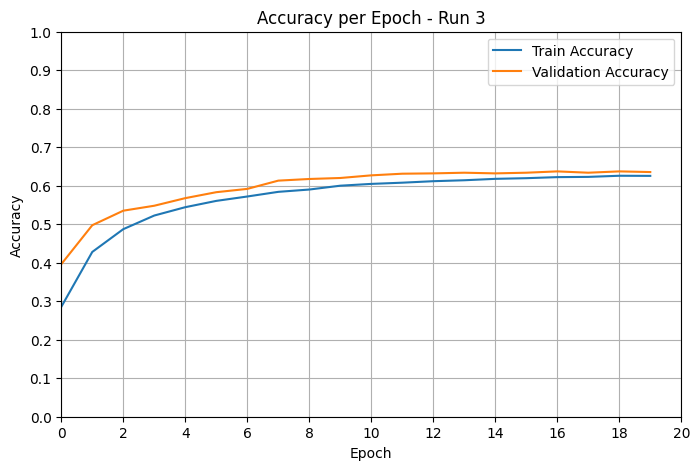

Test accuracy: 0.6355
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


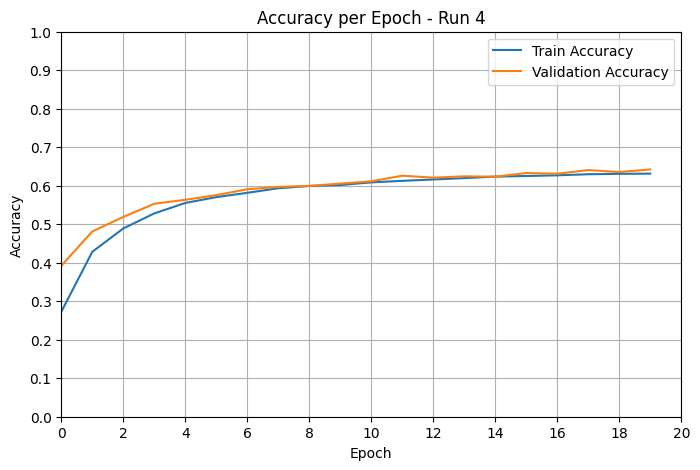

Test accuracy: 0.6424
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


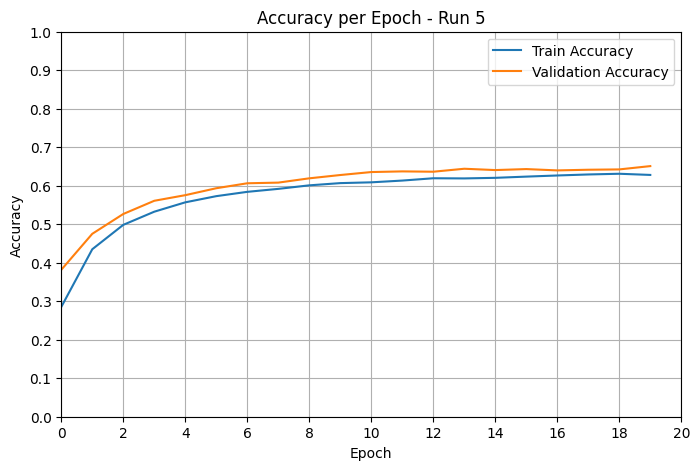

Test accuracy: 0.6509
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training model MLP3 with config: {'layer_sizes': [512, 256], 'activation': 'relu', 'loss': 'mean_squared_error'}
Run 1/5


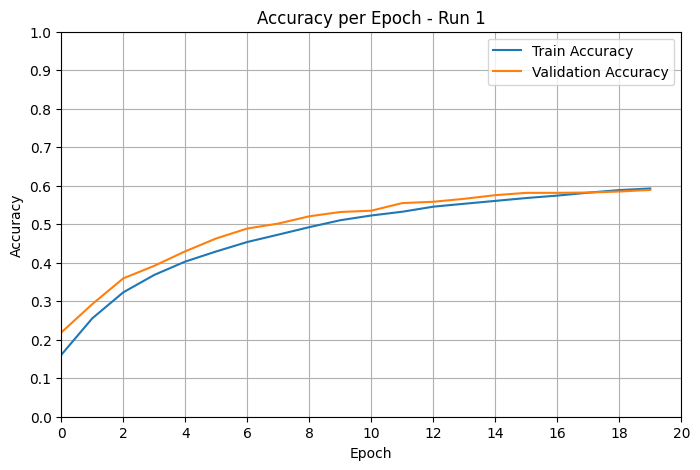

Test accuracy: 0.5892
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


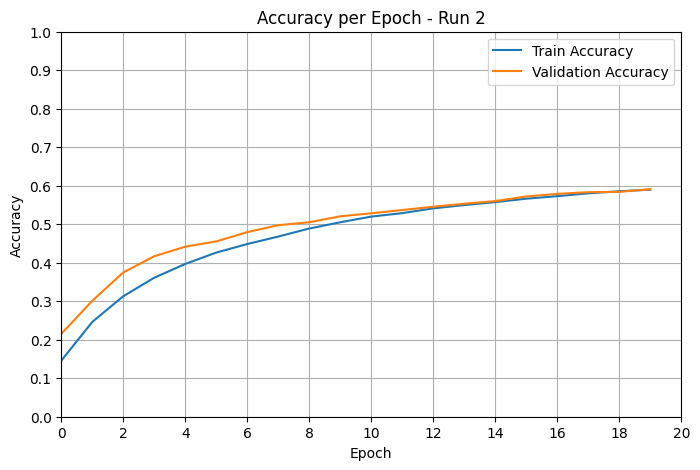

Test accuracy: 0.5909
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


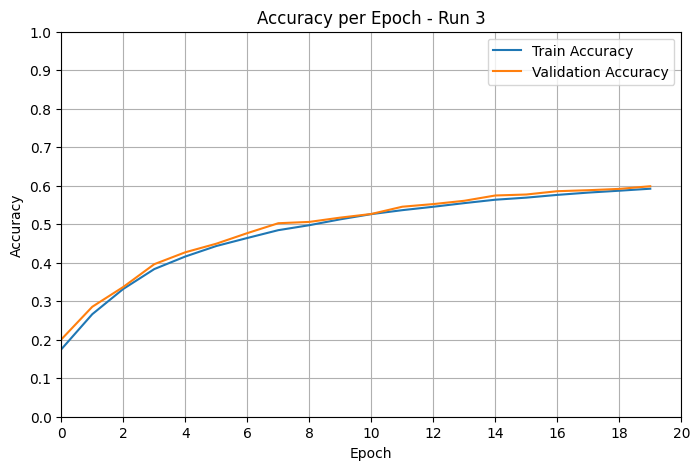

Test accuracy: 0.5986
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


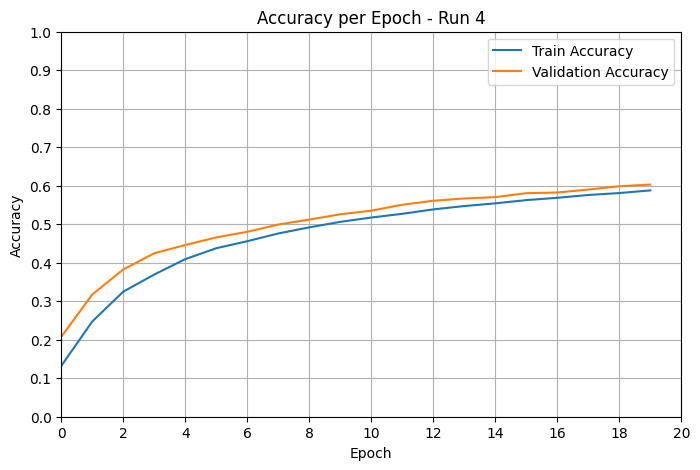

Test accuracy: 0.6029
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


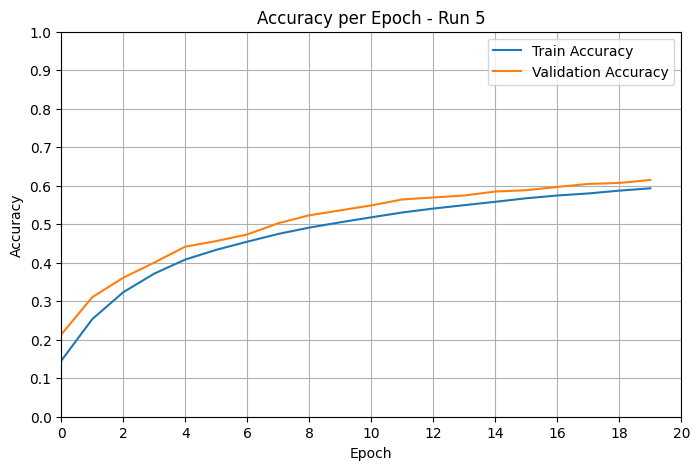

Test accuracy: 0.6149
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training model MLP4 with config: {'layer_sizes': [512, 256], 'activation': 'tanh', 'loss': 'mean_squared_error'}
Run 1/5


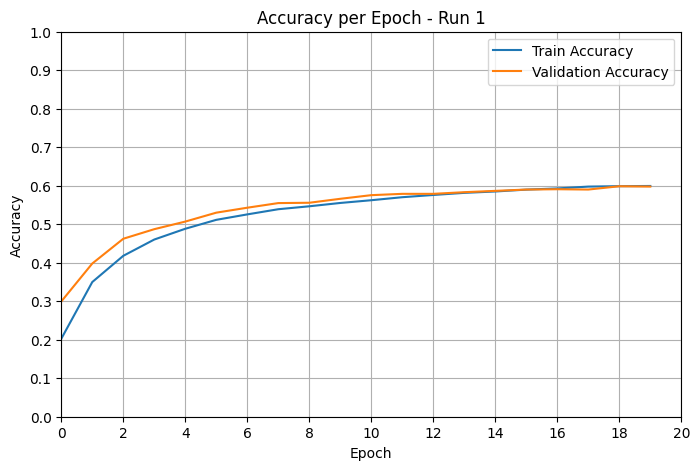

Test accuracy: 0.5978
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


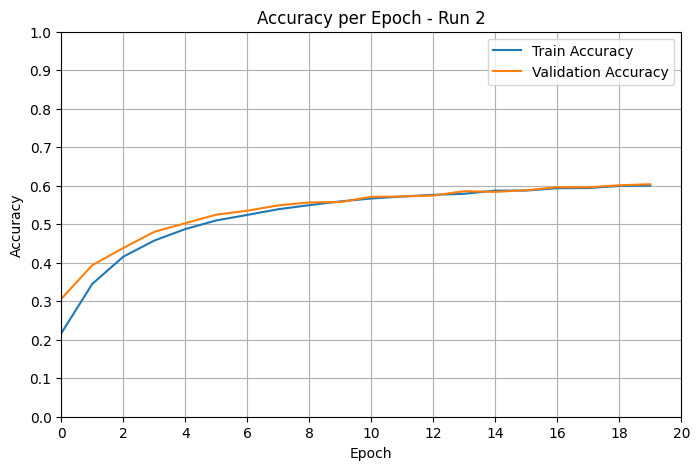

Test accuracy: 0.6038
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


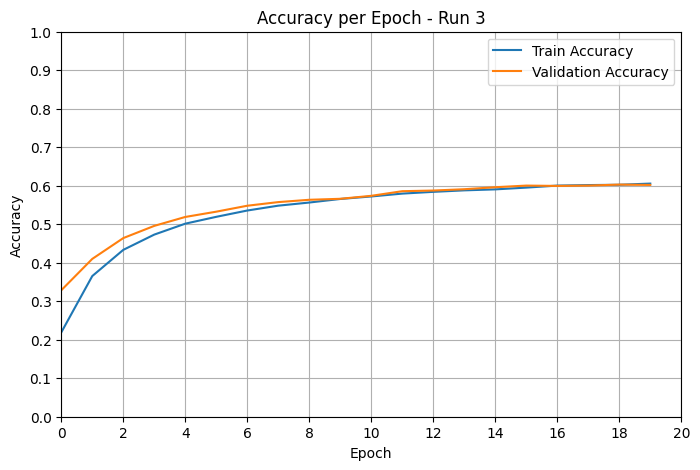

Test accuracy: 0.6021
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


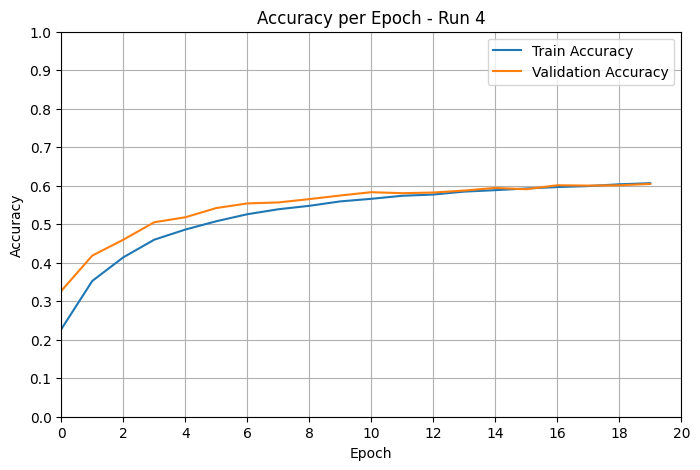

Test accuracy: 0.6046
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Run 5/5


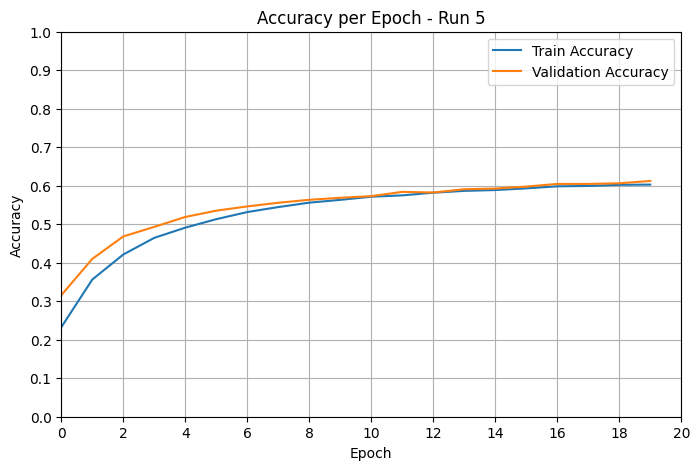

Test accuracy: 0.6123
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training model MLP5 with config: {'layer_sizes': [256, 128, 64, 32], 'activation': 'tanh', 'loss': 'mean_squared_error'}
Run 1/5


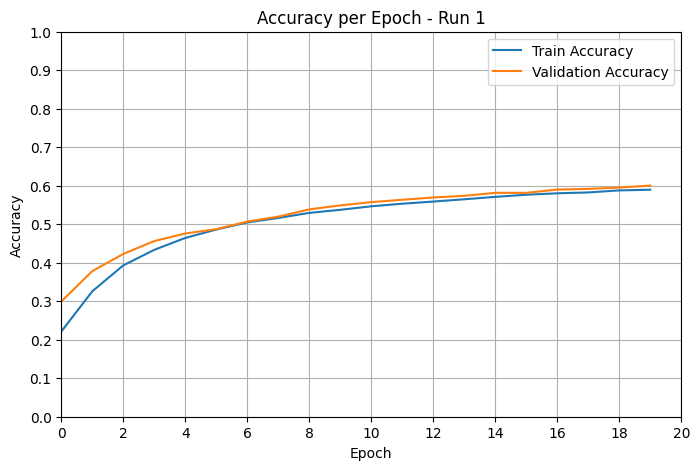

Test accuracy: 0.6003
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 2/5


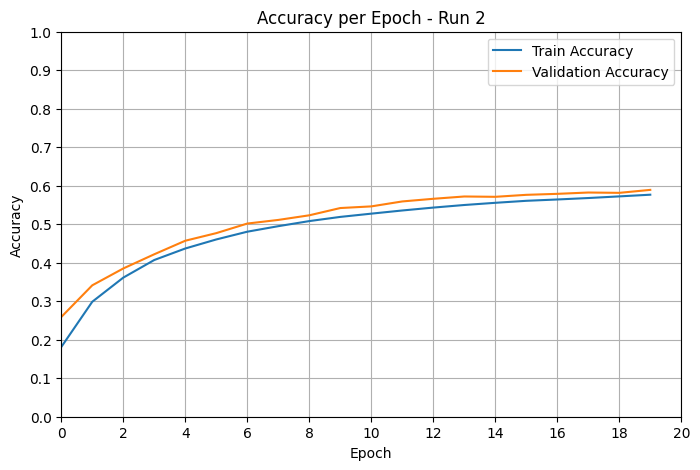

Test accuracy: 0.5892
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


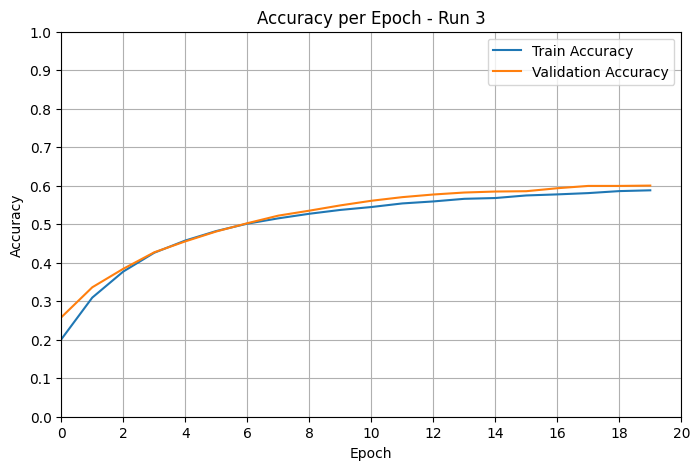

Test accuracy: 0.6003
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 4/5


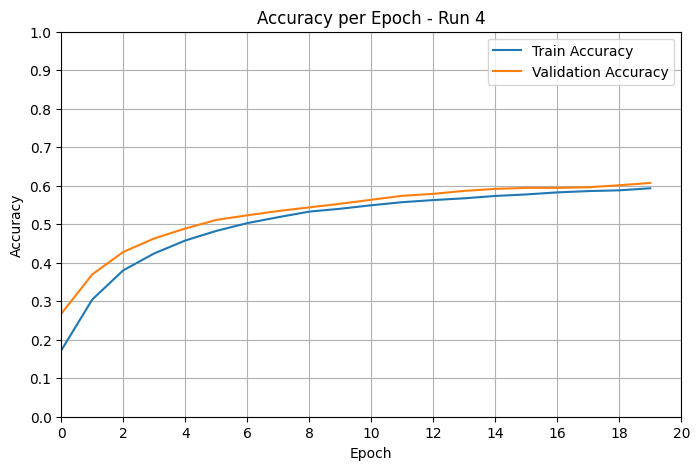

Test accuracy: 0.6072
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 5/5


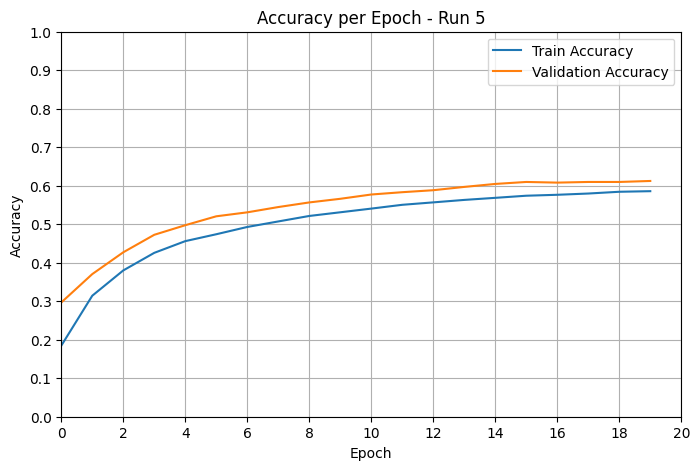

Test accuracy: 0.6123
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [41]:
model_configs = [
    {"layer_sizes": [1024, 512, 64], "activation": "relu", "loss": "mean_squared_error"},
    {"layer_sizes": [1024, 512, 64], "activation": "tanh", "loss": "mean_squared_error"},
    {"layer_sizes": [512, 256], "activation": "relu", "loss": "mean_squared_error"},
    {"layer_sizes": [512, 256], "activation": "tanh", "loss": "mean_squared_error"},
    {"layer_sizes": [256, 128, 64, 32], "activation": "tanh", "loss": "mean_squared_error"}
]

# QuickDraw-10
for i, config in enumerate(model_configs, 1):
    print(f"Training model MLP{i} with config: {config}")
    builder = create_builder(config, num_classes)
    results = train_and_evaluate(builder, X_train_pca, y_train_onehot, X_test_pca, y_test_onehot, runs=5)
    all_results[f"MLP{i}"] = results

Training model MLP1 on QuickDraw-Animals
Run 1/5


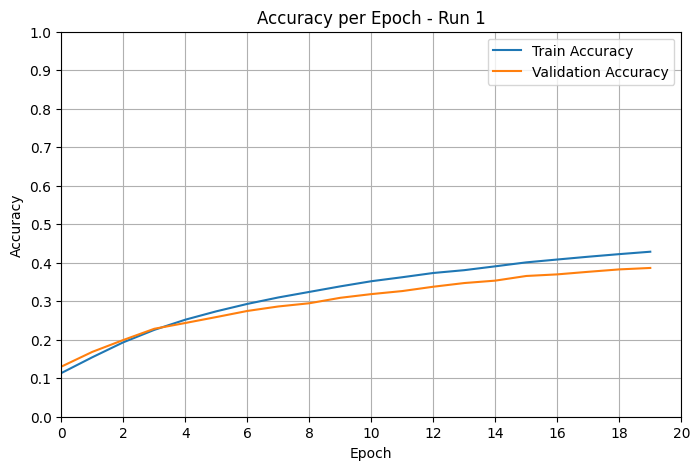

Test accuracy: 0.3864
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Run 2/5


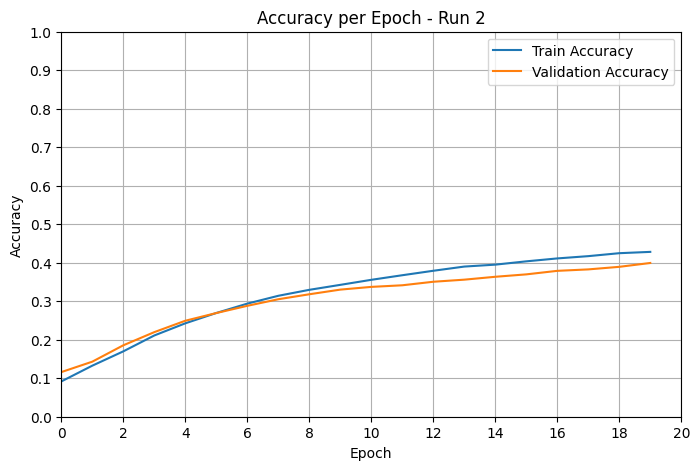

Test accuracy: 0.3993
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


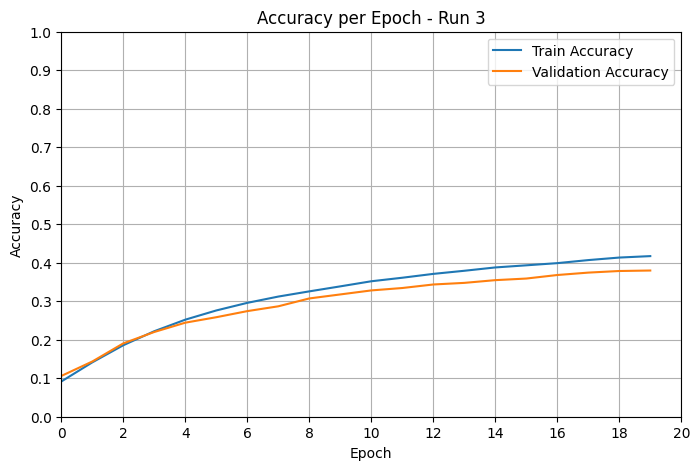

Test accuracy: 0.3797
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Run 4/5


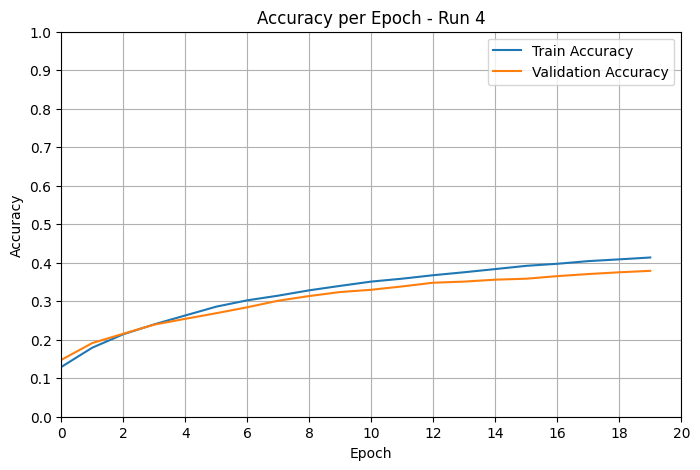

Test accuracy: 0.3789
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Run 5/5


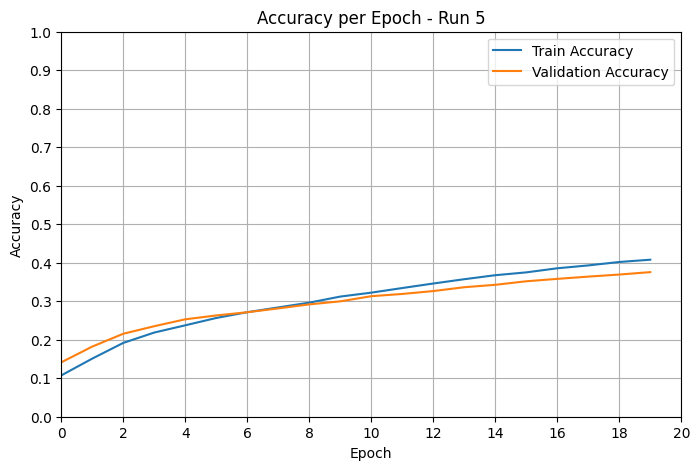

Test accuracy: 0.3756
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training model MLP2 on QuickDraw-Animals
Run 1/5


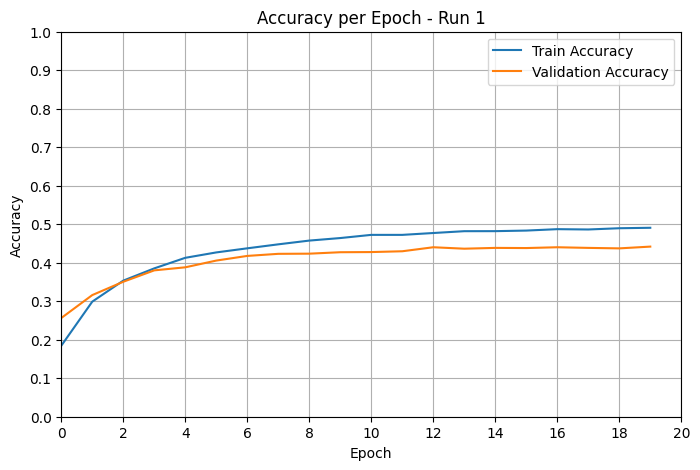

Test accuracy: 0.4419
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Run 2/5


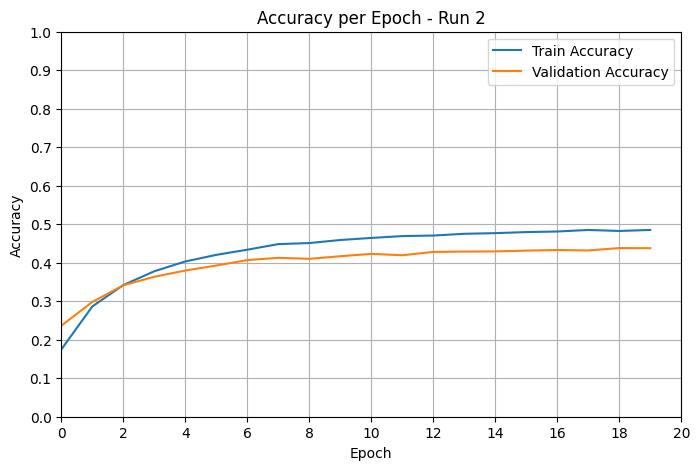

Test accuracy: 0.4377
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/5


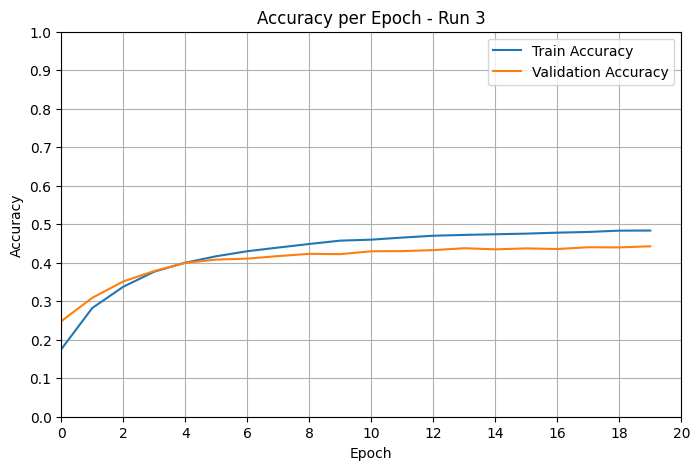

Test accuracy: 0.4427
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Run 4/5


In [ ]:
# QuickDraw-Animals
for i, config in enumerate(model_configs, 1):
    print(f"Training model MLP{i} on QuickDraw-Animals")
    builder = create_builder(config, num_classes_animals)
    results = train_and_evaluate(
        builder,
        X_train_animals_pca,
        y_train_animals_onehot,
        X_test_animals_pca,
        y_test_animals_onehot,
        runs=5
    )
    all_results[f"MLP{i}_animals"] = results


In [ ]:
for model_name, results in all_results.items():
    accuracies = [res['accuracy'] for res in results]
    median_acc = np.median(accuracies)
    print(f"{model_name}: Median accuracy over {len(results)} runs = {median_acc:.4f}")